In [1]:
# Main Libraries
import pandas as pd 
import numpy as np
from numpy import *

#Nice graphing tools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly
import plotly.offline as py
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.tools as tls

from multiprocessing import Pool
from itertools import product
import knntsp
import warnings
import importlib
warnings.filterwarnings('ignore')

import pickle

NUM_CORES = 4
PREPROCESSED_PATH = './../preprocessed/'
RESULTS_PATH = './../results/'

In [2]:
# Reading groupped data
def read_groupped_data(filename):
    timeSeries = pd.read_csv(filename,index_col=['Unnamed: 0'], parse_dates=['Unnamed: 0'])
    timeSeries.rename(columns=lambda x: eval(x), inplace=True)
    timeSeries.index = pd.to_datetime(timeSeries.index)
    return timeSeries

In [3]:
NUM_CORES = 4
RANDOM_STATE = 1
TRAIN_SIZE = 0.86

In [4]:
# Reading time series data
timeSeries = read_groupped_data(PREPROCESSED_PATH + 'median_timeseries.csv')

In [5]:
# Removing time series without data
timeSeries = timeSeries.dropna(axis=1)

In [6]:
cluster_labels = pd.read_csv(PREPROCESSED_PATH + 'median_based_cluster_labels.csv', header=-1, index_col=[0])
cluster_labels.columns = ['label']
cluster_labels.head()

simple_w_k = pd.read_csv(PREPROCESSED_PATH + 'simple_knntsp_w_k.csv',index_col=[0])
cluster_w_k = pd.read_csv(PREPROCESSED_PATH + 'cluster_knntsp_w_k.csv')

simple_w_k.loc[0]['w']

3.0

In [7]:
importlib.reload(knntsp)

results_cluster_knn_real = []
results_cluster_knn_predicted = []

results_simple_knn_real = []
results_simple_knn_predicted = []

to_run_cluster_real = []
to_run_cluster_predicted = []

to_run_simple_real = []
to_run_simple_predicted = []

X = timeSeries.copy()
_cluster_labels = cluster_labels.copy()

i = 0
for column in X.columns:
    label = cluster_labels.iloc[X.T.index.get_loc(column)][0]
    
    clust_w_k = cluster_w_k[cluster_w_k.cluster_label==label]
    w_k = simple_w_k.loc[i]
#     if len(clust_w_k) == 0:
#         clust_w_k = simple_w_k
    
    to_run_cluster_real.append([X, column, _cluster_labels, int(clust_w_k.iloc[0]['w']), int(clust_w_k.iloc[0]['k']), TRAIN_SIZE, False, True])
    to_run_cluster_predicted.append([X, column, _cluster_labels, int(clust_w_k.iloc[0]['w']), int(clust_w_k.iloc[0]['k']), TRAIN_SIZE, False, False])
    
    to_run_simple_predicted.append([X, column, int(w_k['w']), int(w_k['k']), TRAIN_SIZE, False, label, False])
    to_run_simple_real.append([X, column, int(w_k['w']), int(w_k['k']), TRAIN_SIZE, False, label, True])
    i += 1
    
with Pool(NUM_CORES) as pool:
    results_cluster_knn_real = pool.starmap(knntsp.predict_with_cluster_knn, to_run_cluster_real)
    results_simple_knn_real = pool.starmap(knntsp.predict_with_knn, to_run_simple_real)
    results_cluster_knn_predicted = pool.starmap(knntsp.predict_with_cluster_knn, to_run_cluster_predicted)
    results_simple_knn_predicted = pool.starmap(knntsp.predict_with_knn, to_run_simple_predicted)

In [8]:
SAVE_PICKLE_RESULTS = True

if SAVE_PICKLE_RESULTS:
    output = open(RESULTS_PATH + 'median_excluded_w_k_cluster_real.pk', 'wb')
    pickle.dump(results_cluster_knn_real, output)
    output.close()
    
    output = open(RESULTS_PATH + 'median_excluded_w_k_simple_real.pk', 'wb')
    pickle.dump(results_simple_knn_real, output)
    output.close()
    
    output = open(RESULTS_PATH + 'median_excluded_w_k_cluster_predicted.pk', 'wb')
    pickle.dump(results_cluster_knn_predicted, output)
    output.close()
    
    output = open(RESULTS_PATH + 'median_excluded_w_k_simple_predicted.pk', 'wb')
    pickle.dump(results_simple_knn_predicted, output)
    output.close()   

In [9]:
infile = open(RESULTS_PATH + 'median_excluded_w_k_cluster_real.pk', 'rb')
cluster_real = pickle.load(infile)
infile.close()

infile = open(RESULTS_PATH + 'median_excluded_w_k_simple_real.pk', 'rb')
simple_real = pickle.load(infile)
infile.close()

infile = open(RESULTS_PATH + 'median_excluded_w_k_cluster_predicted.pk', 'rb')
cluster_predicted = pickle.load(infile)
infile.close()

infile = open(RESULTS_PATH + 'median_excluded_w_k_simple_predicted.pk', 'rb')
simple_predicted = pickle.load(infile)
infile.close()   

Cluster real:  0.6661001813252958
Cluster predicted:  1.7591409228726942
Simple real:  0.6257022505619738
Simple predicted:  0.870841209391046


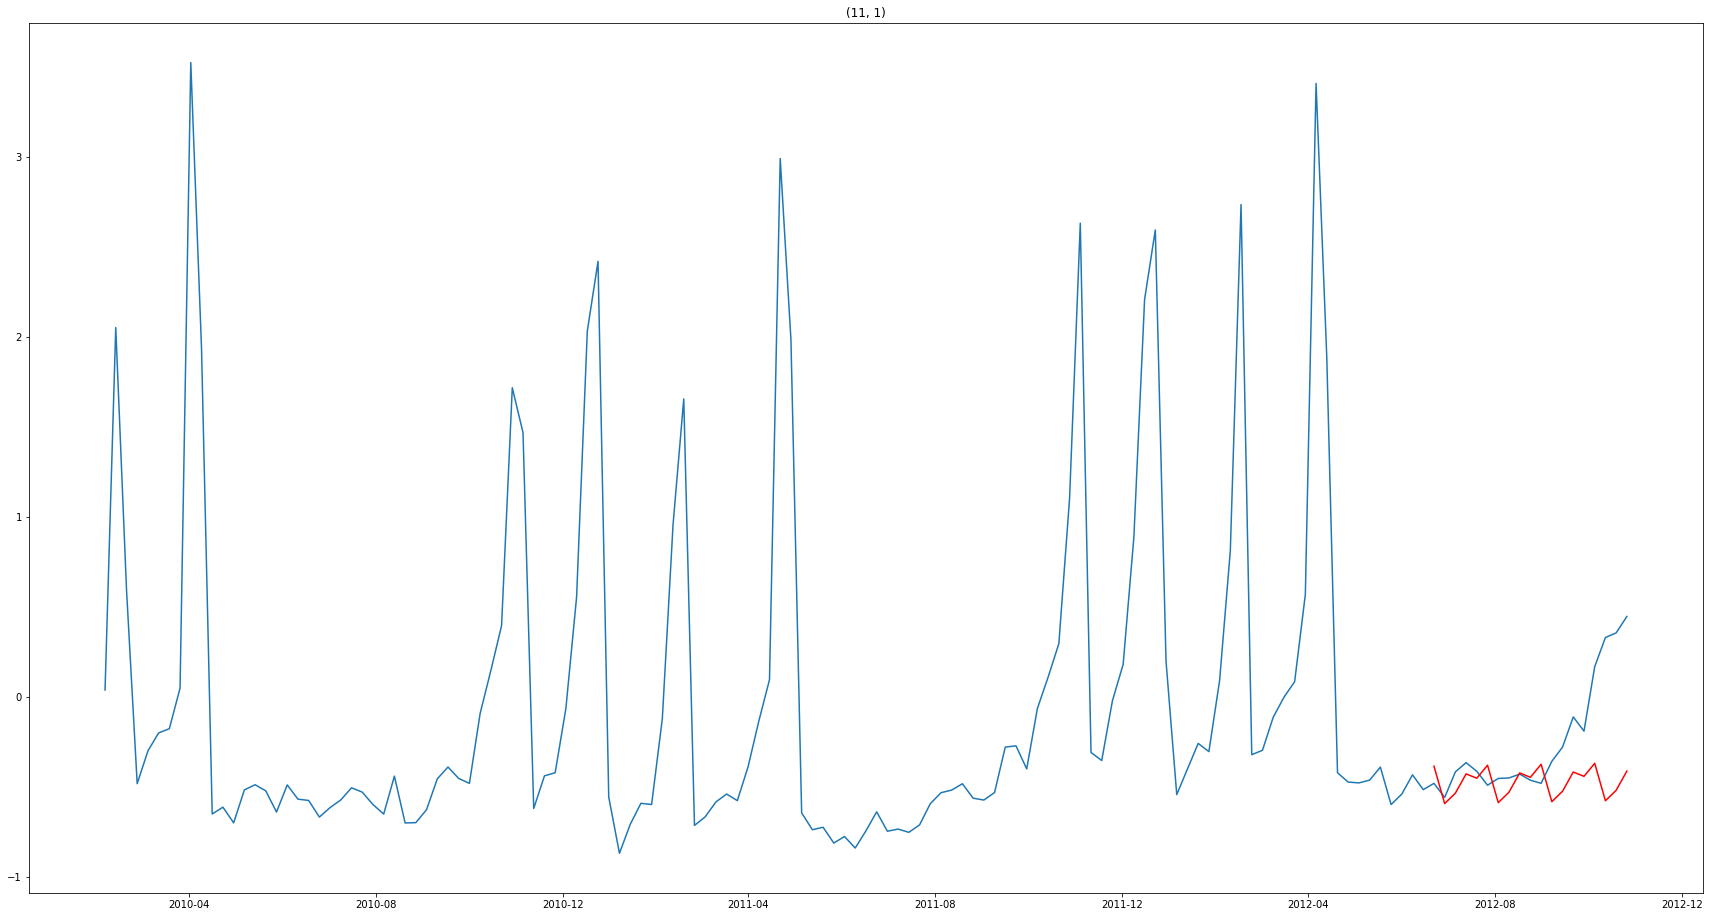

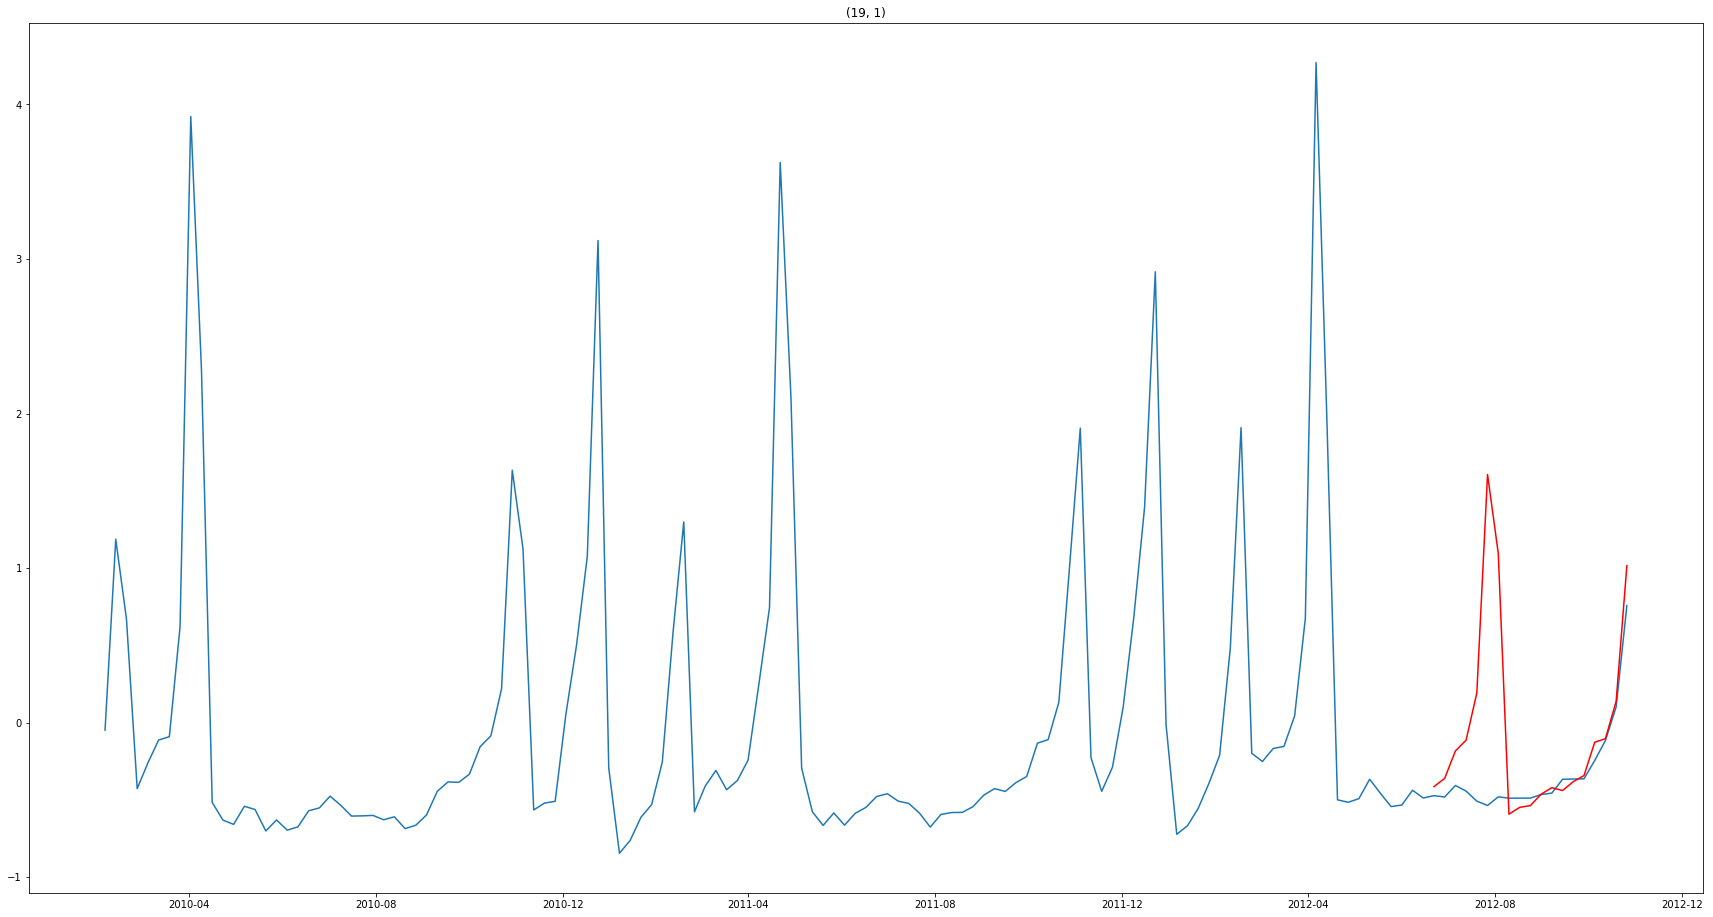

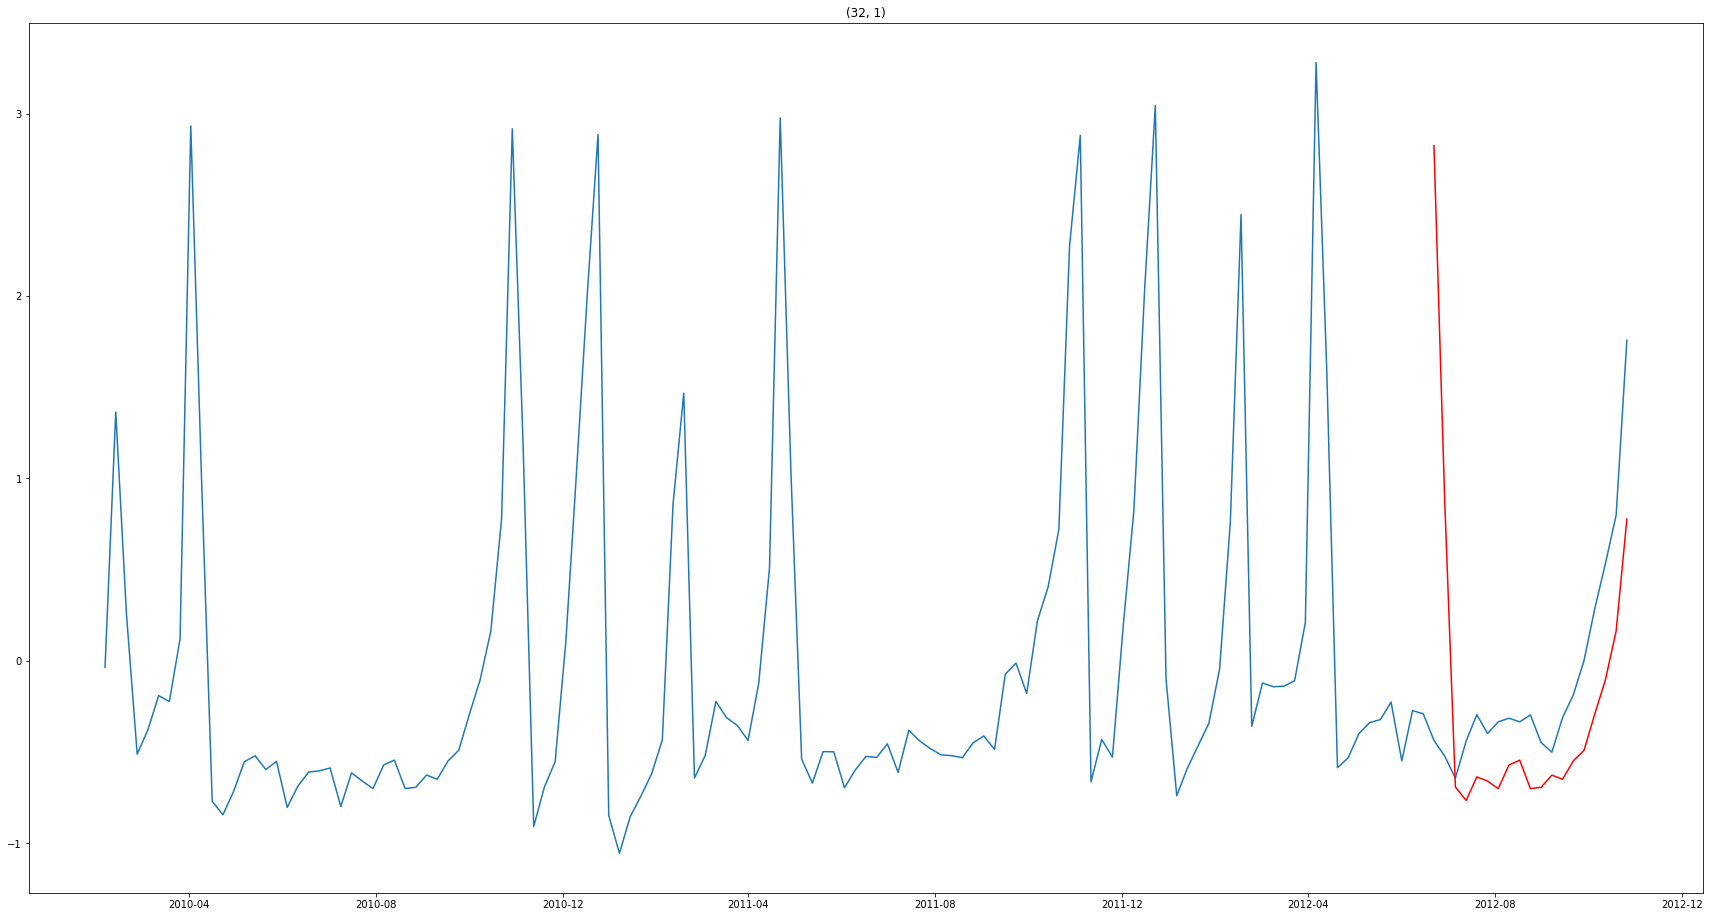

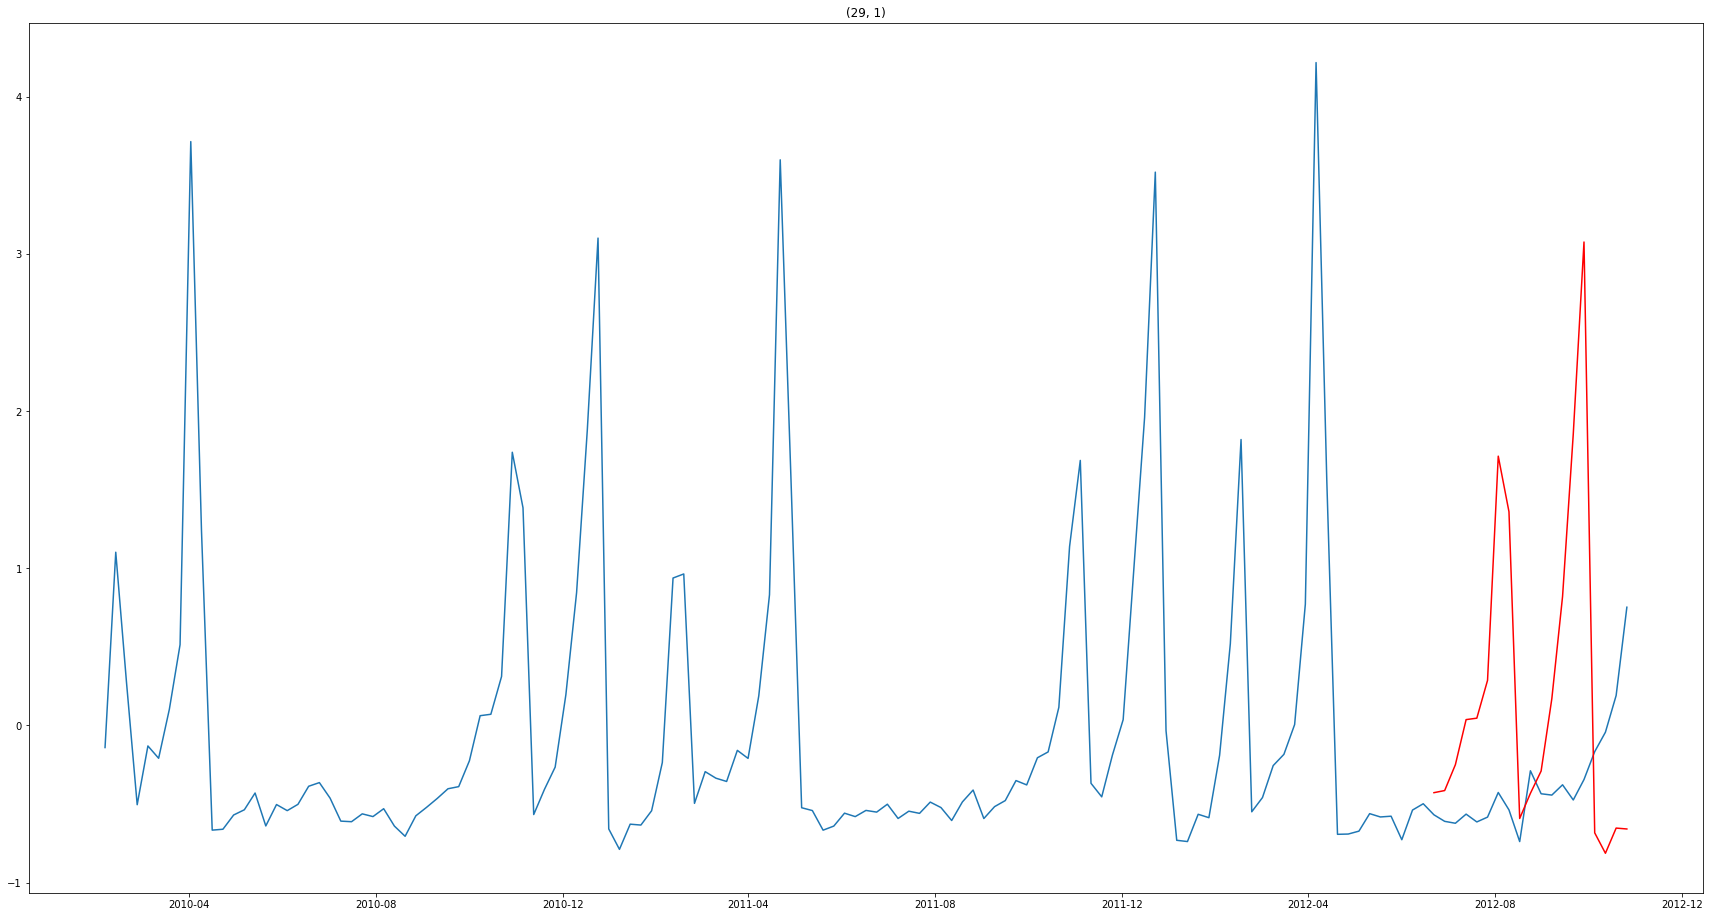

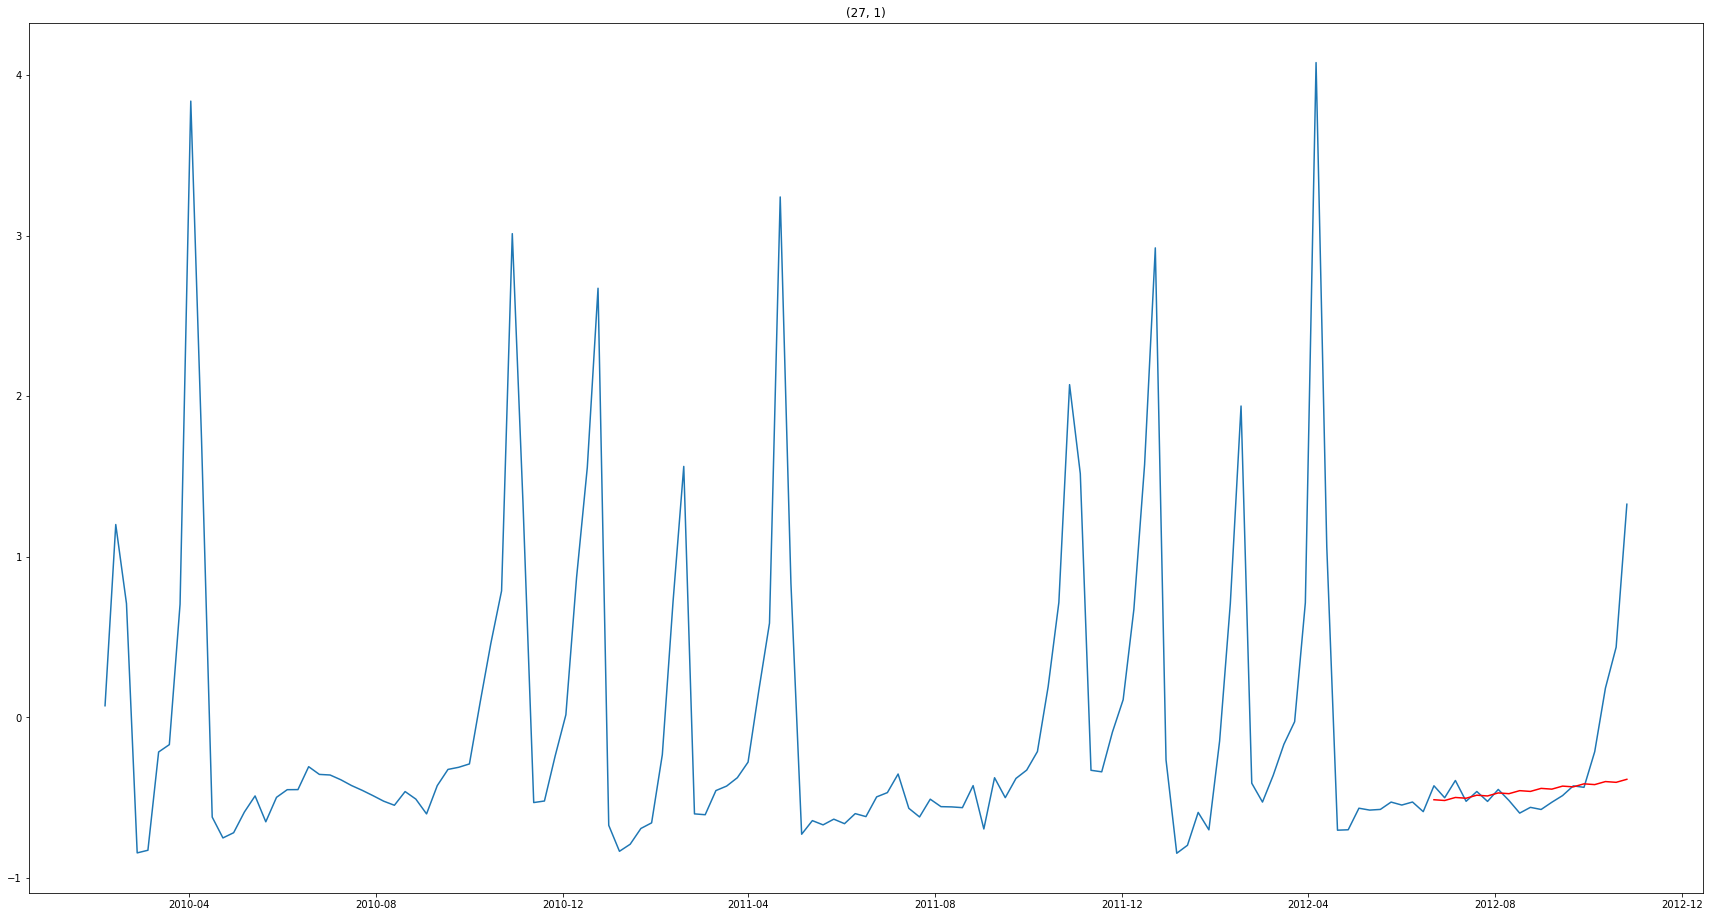

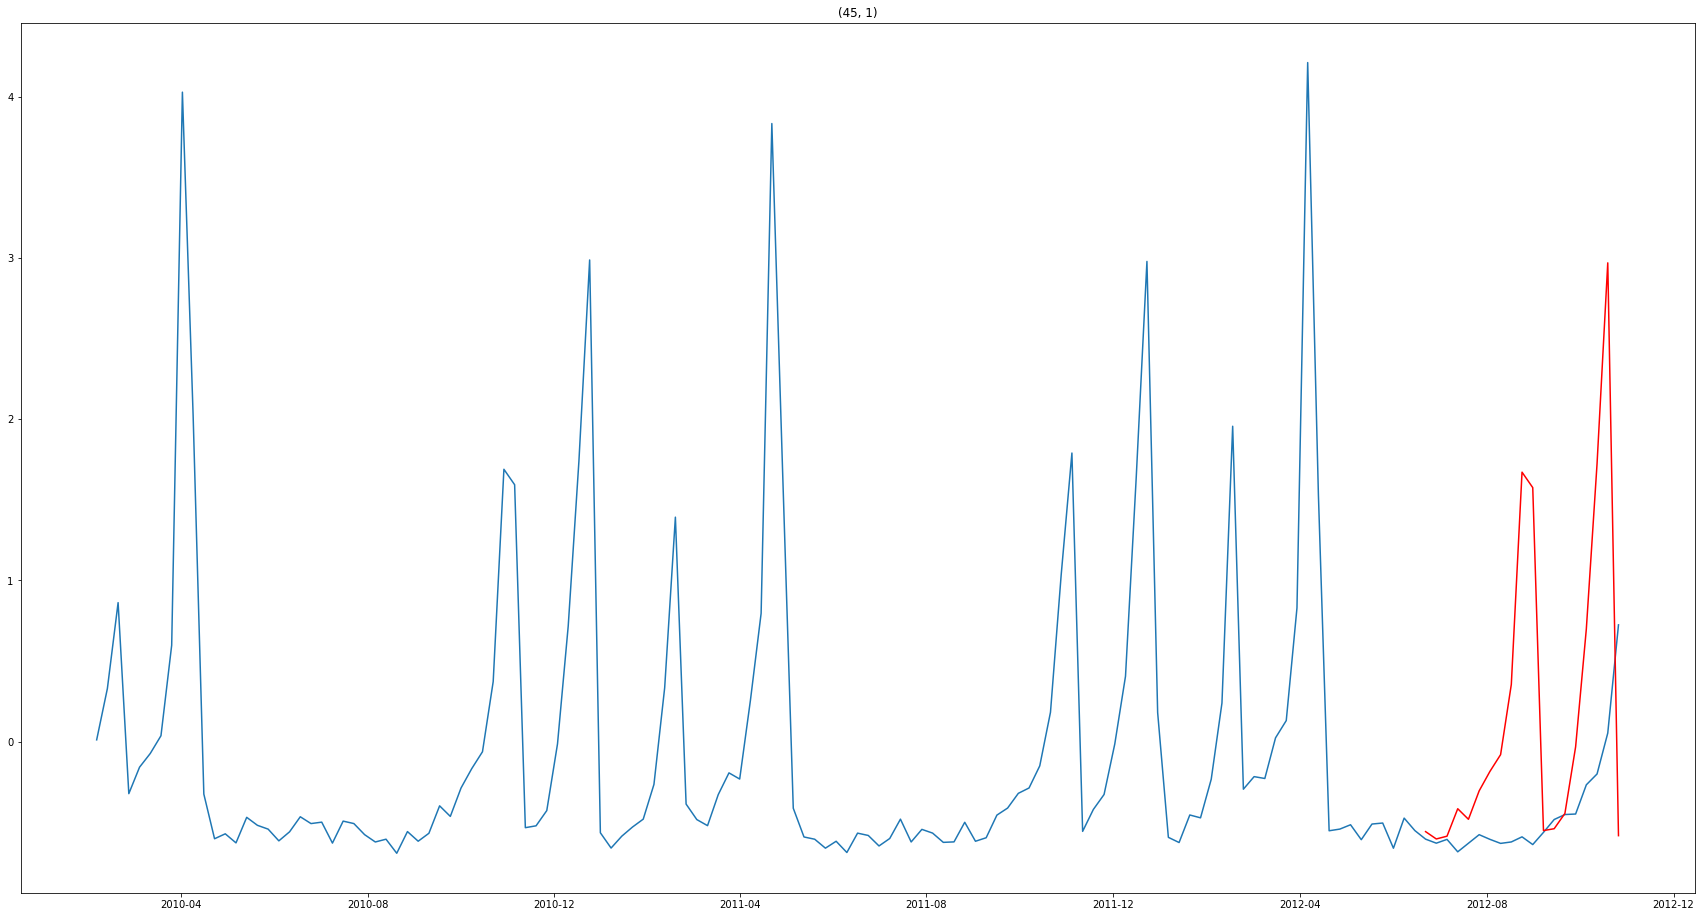

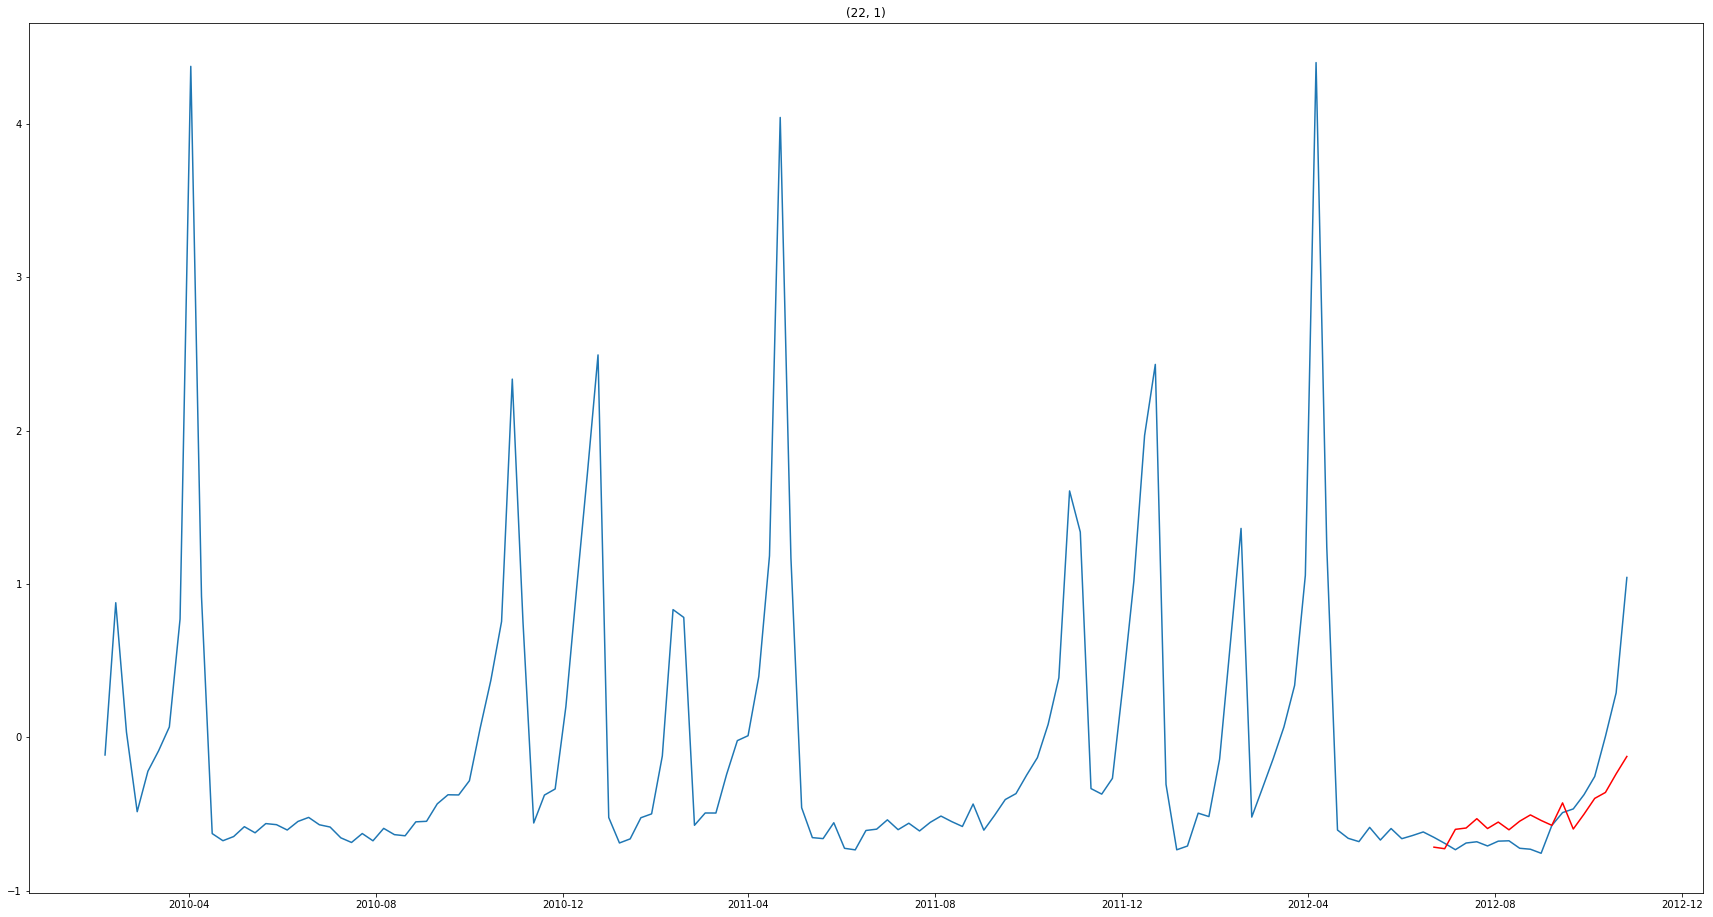

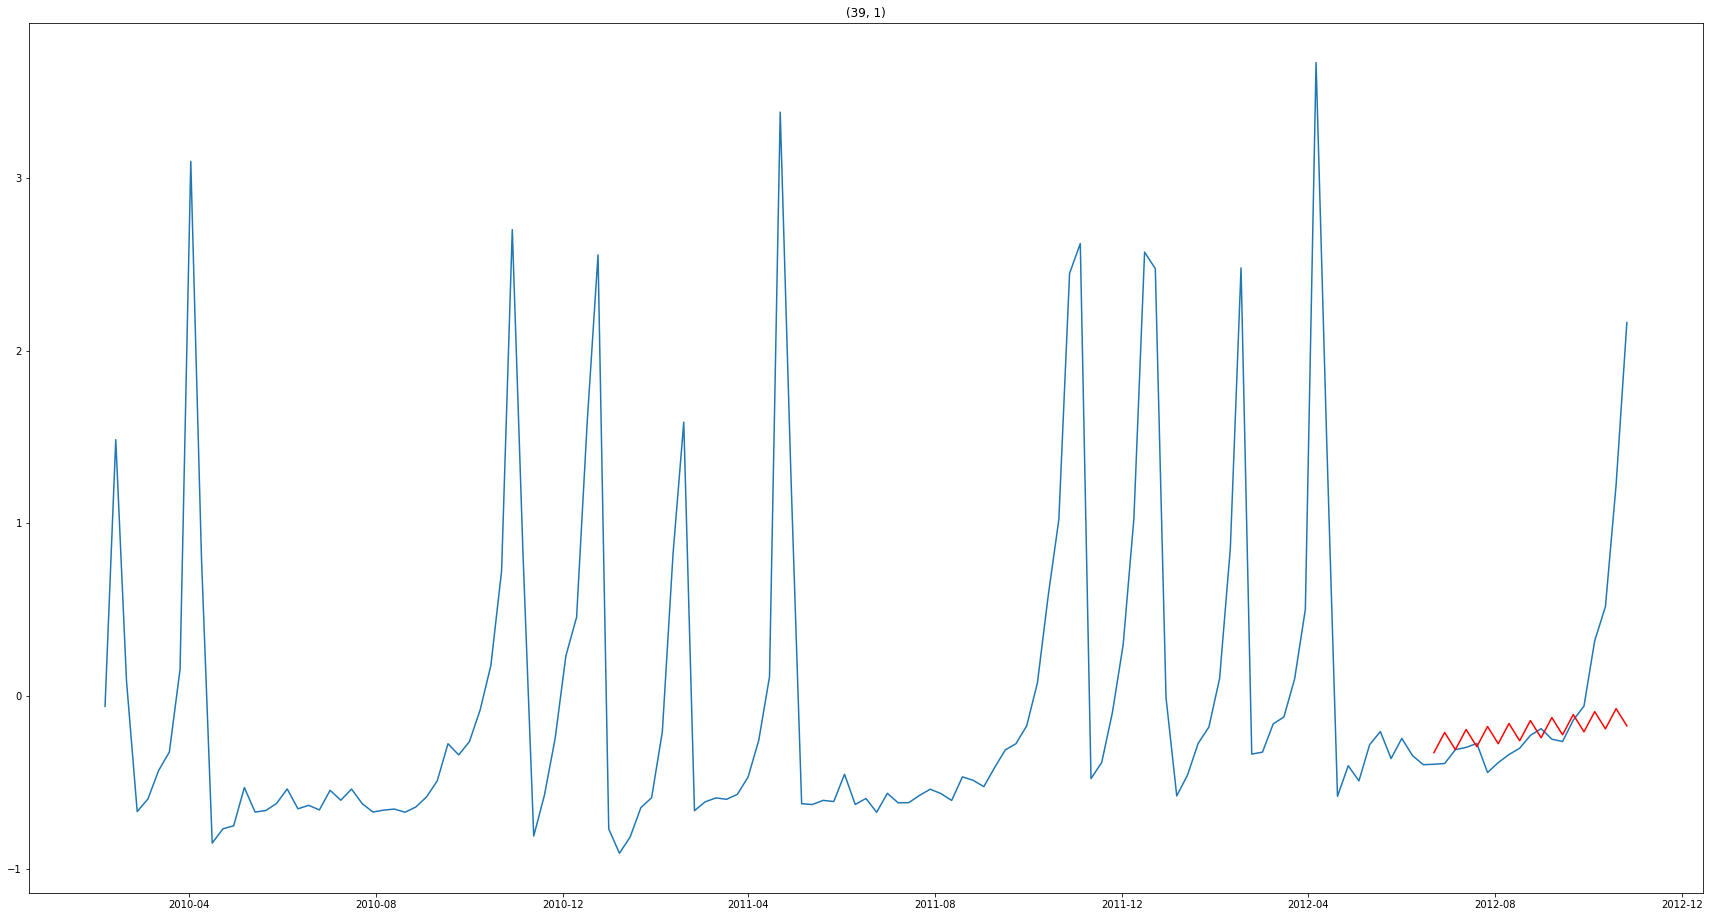

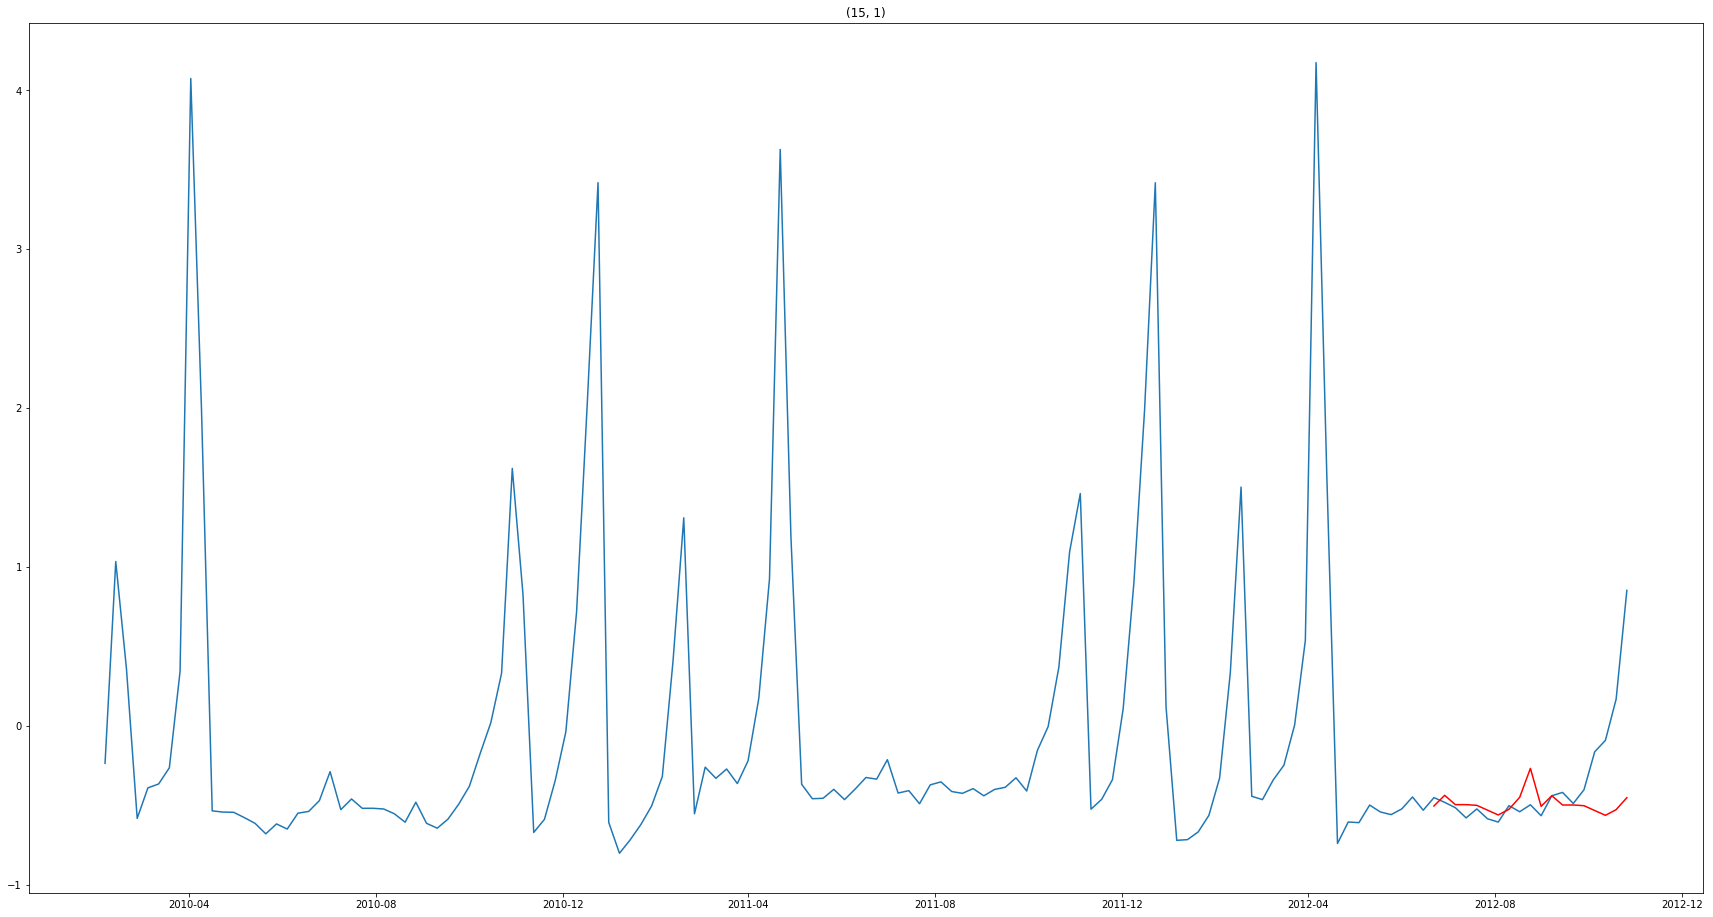

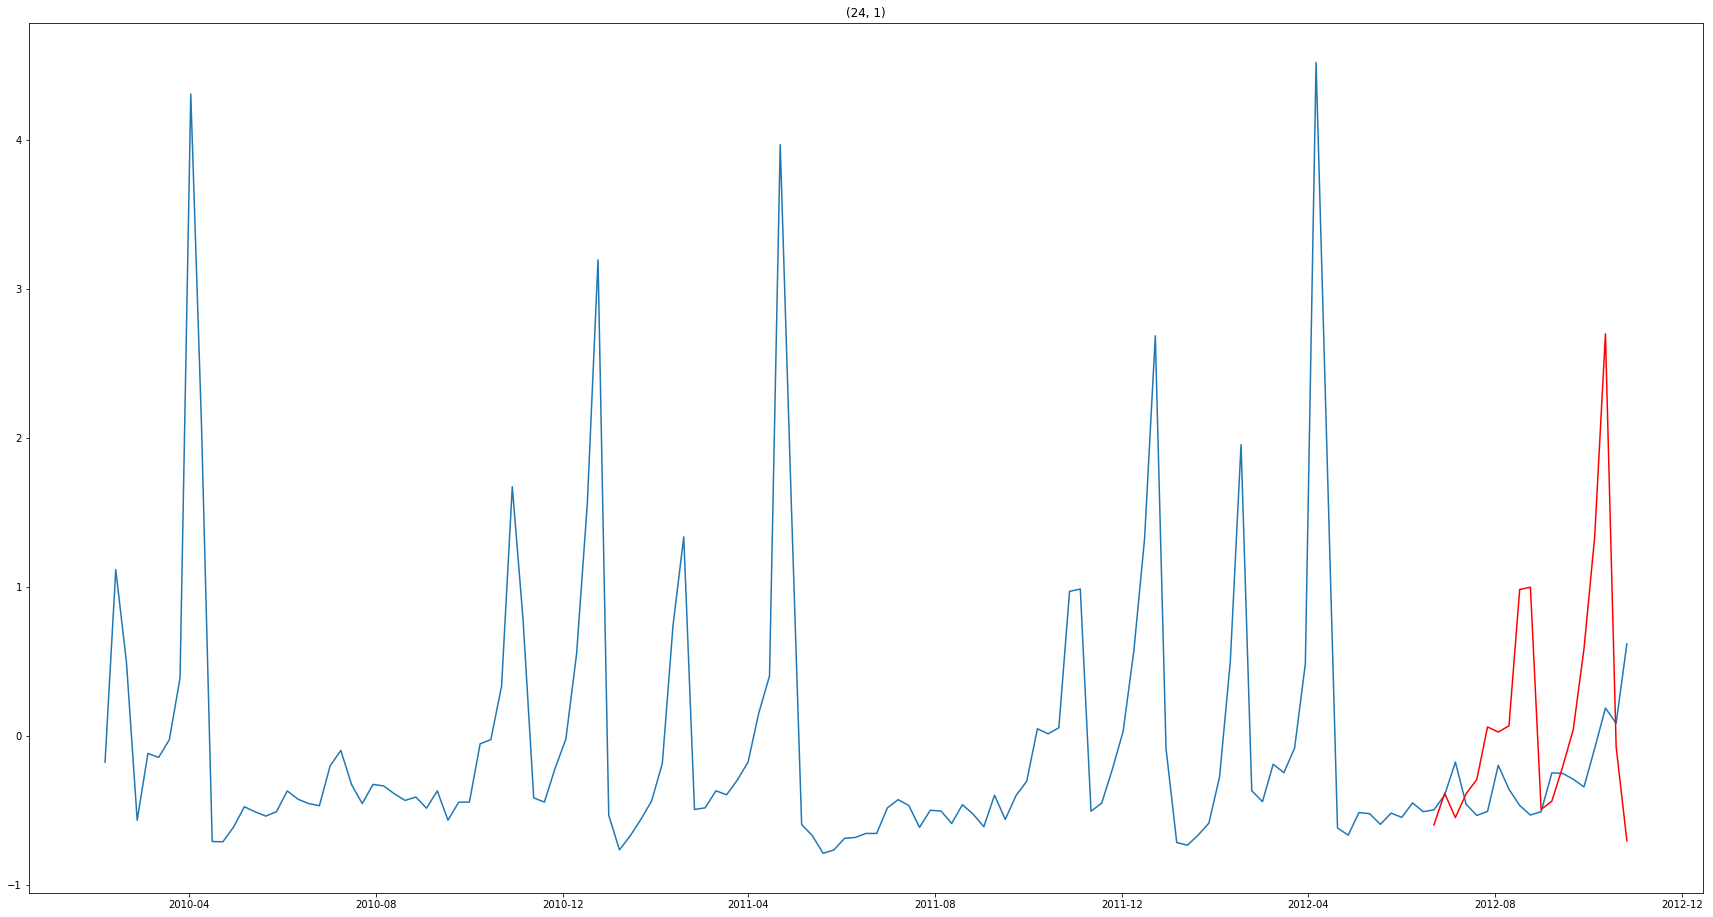

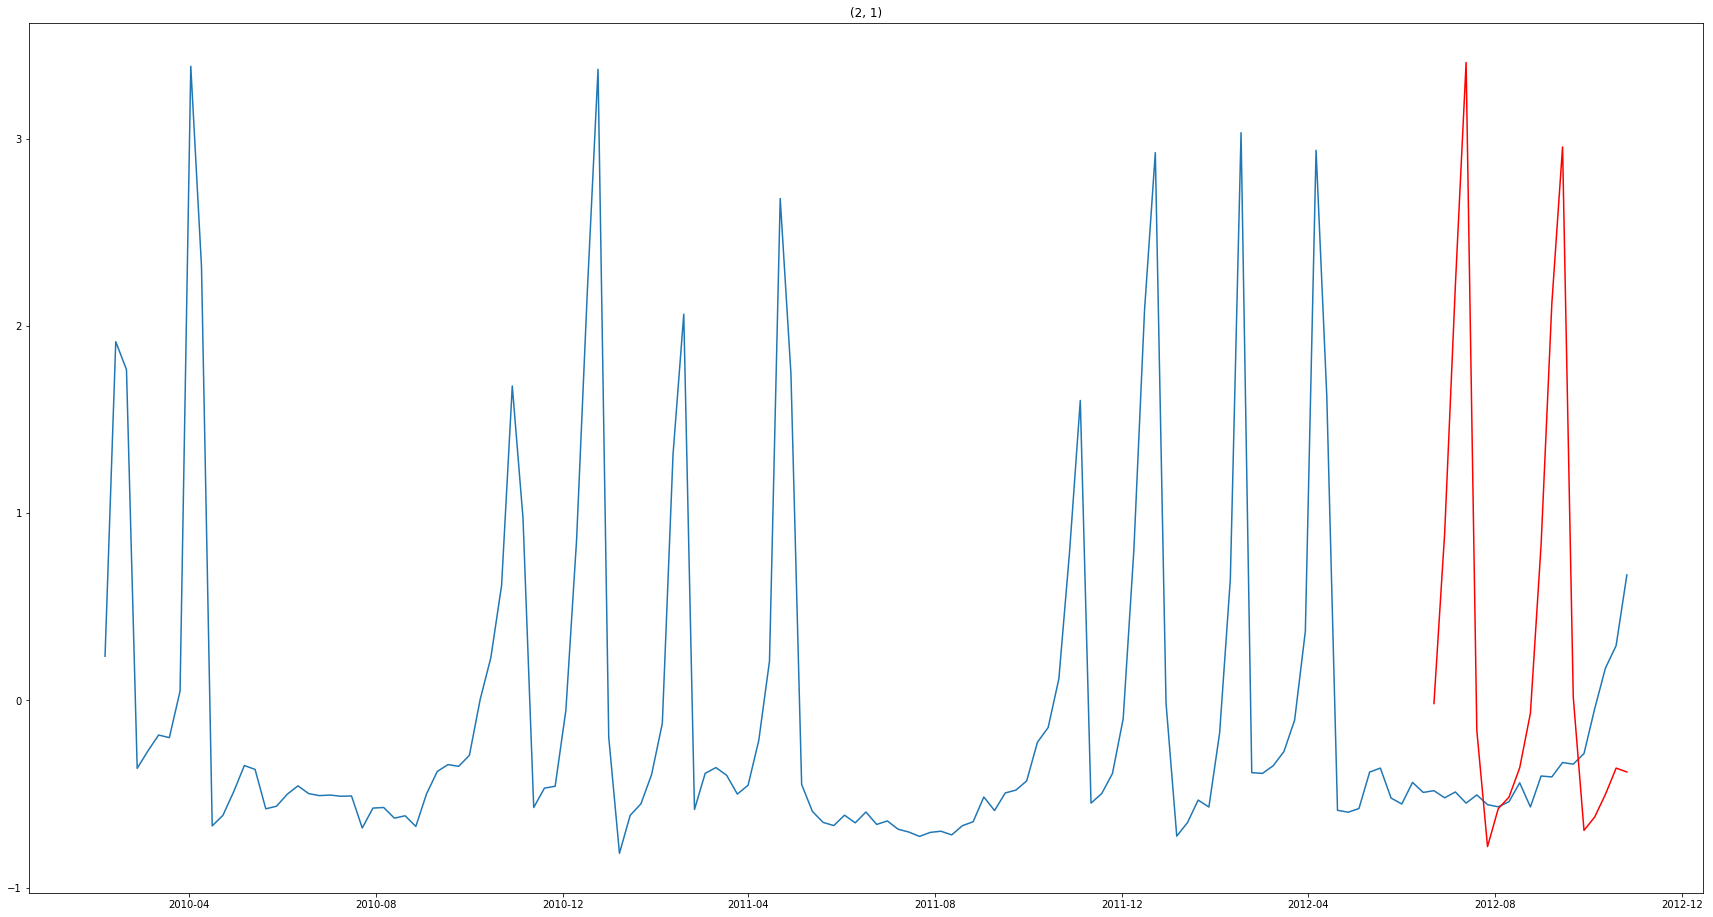

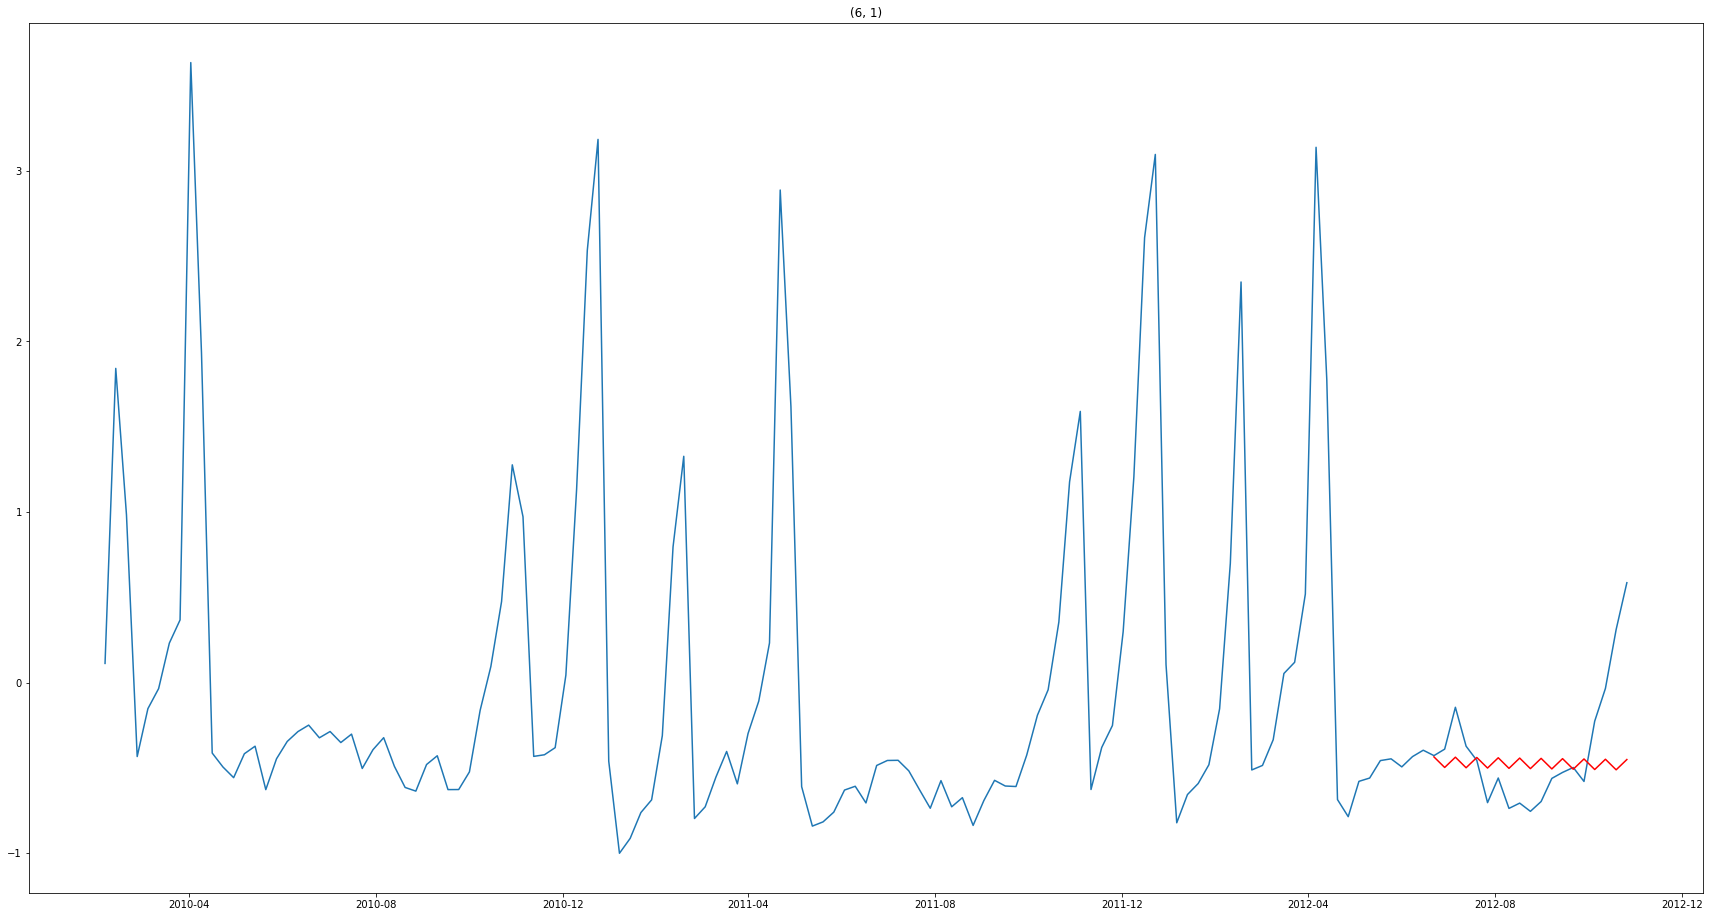

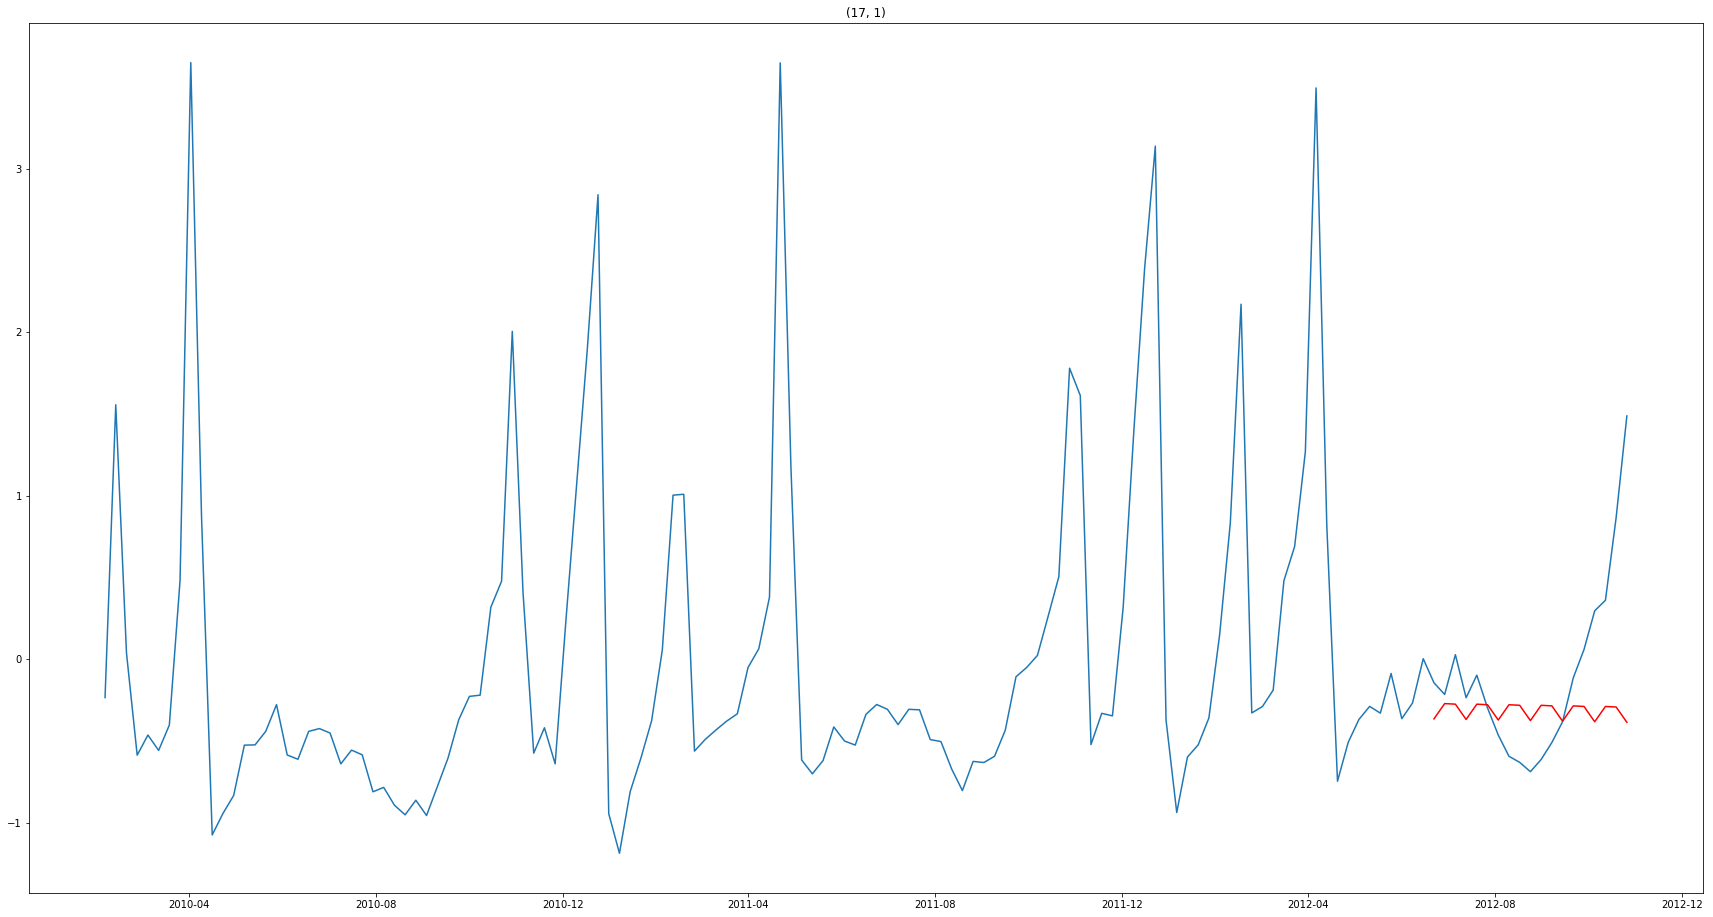

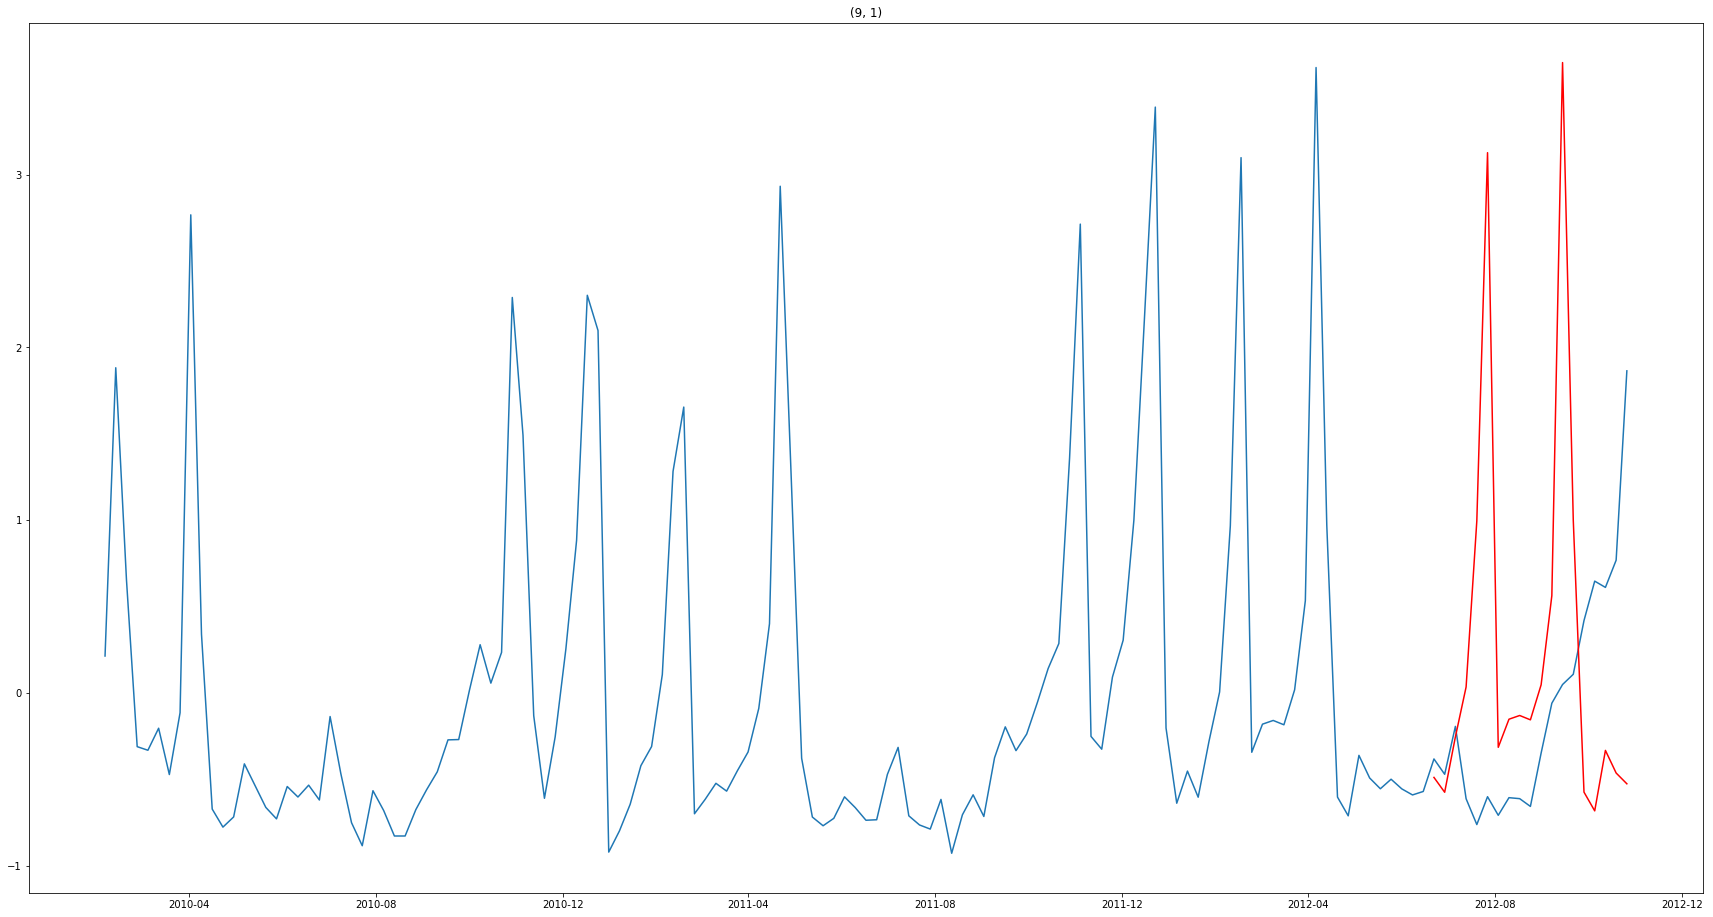

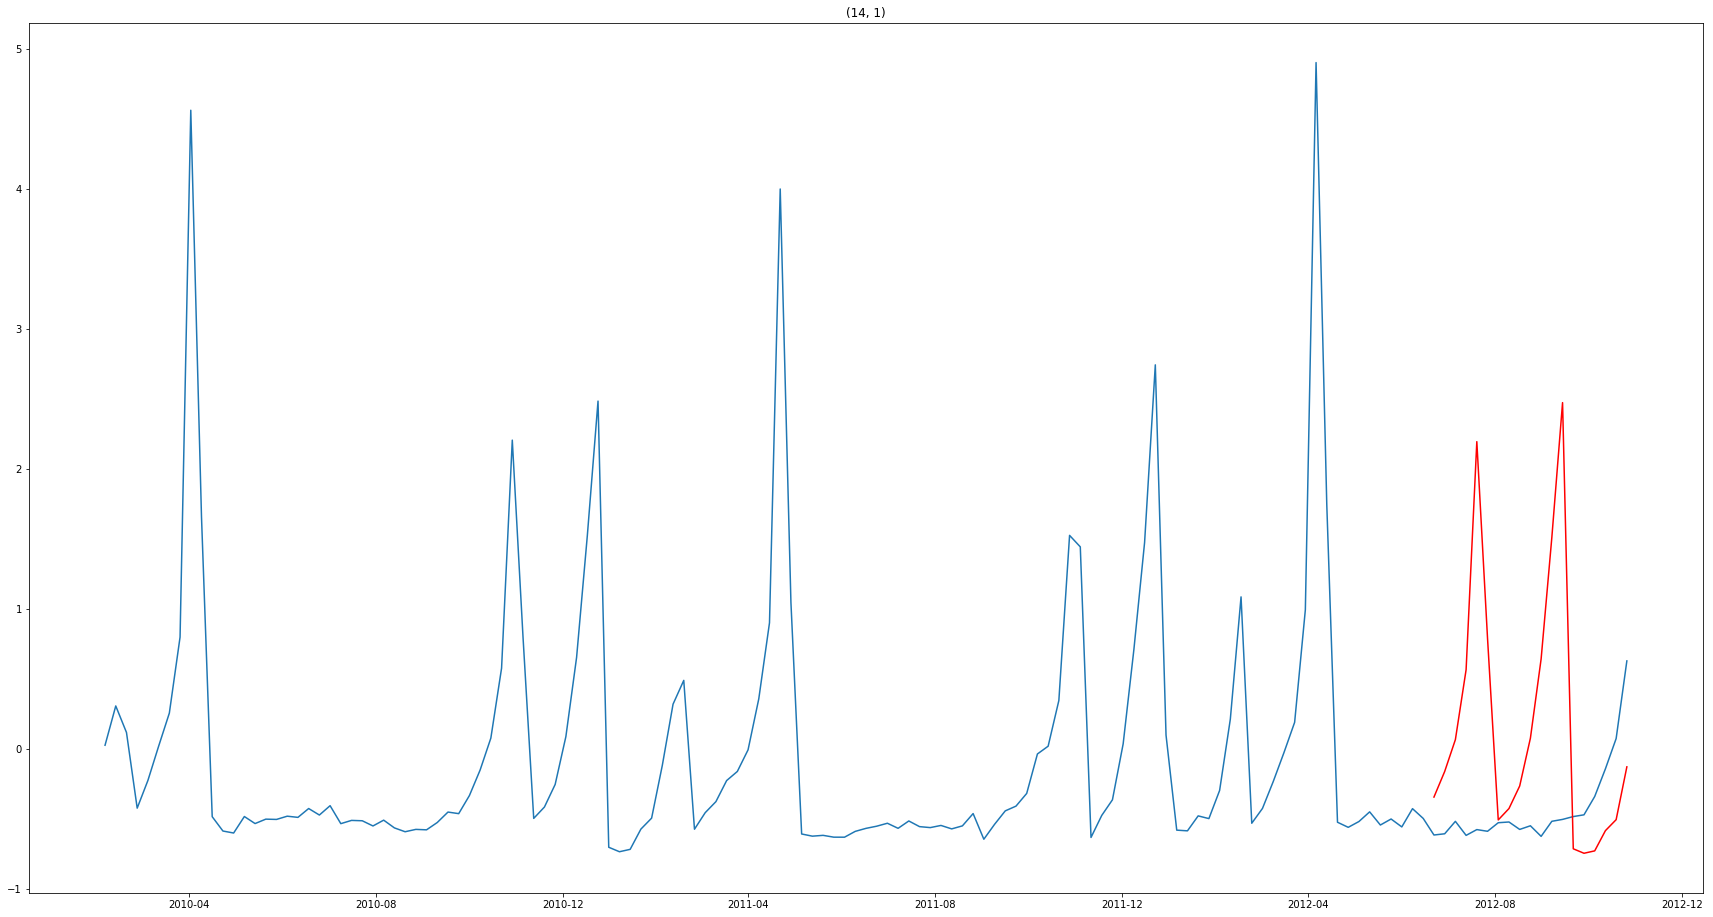

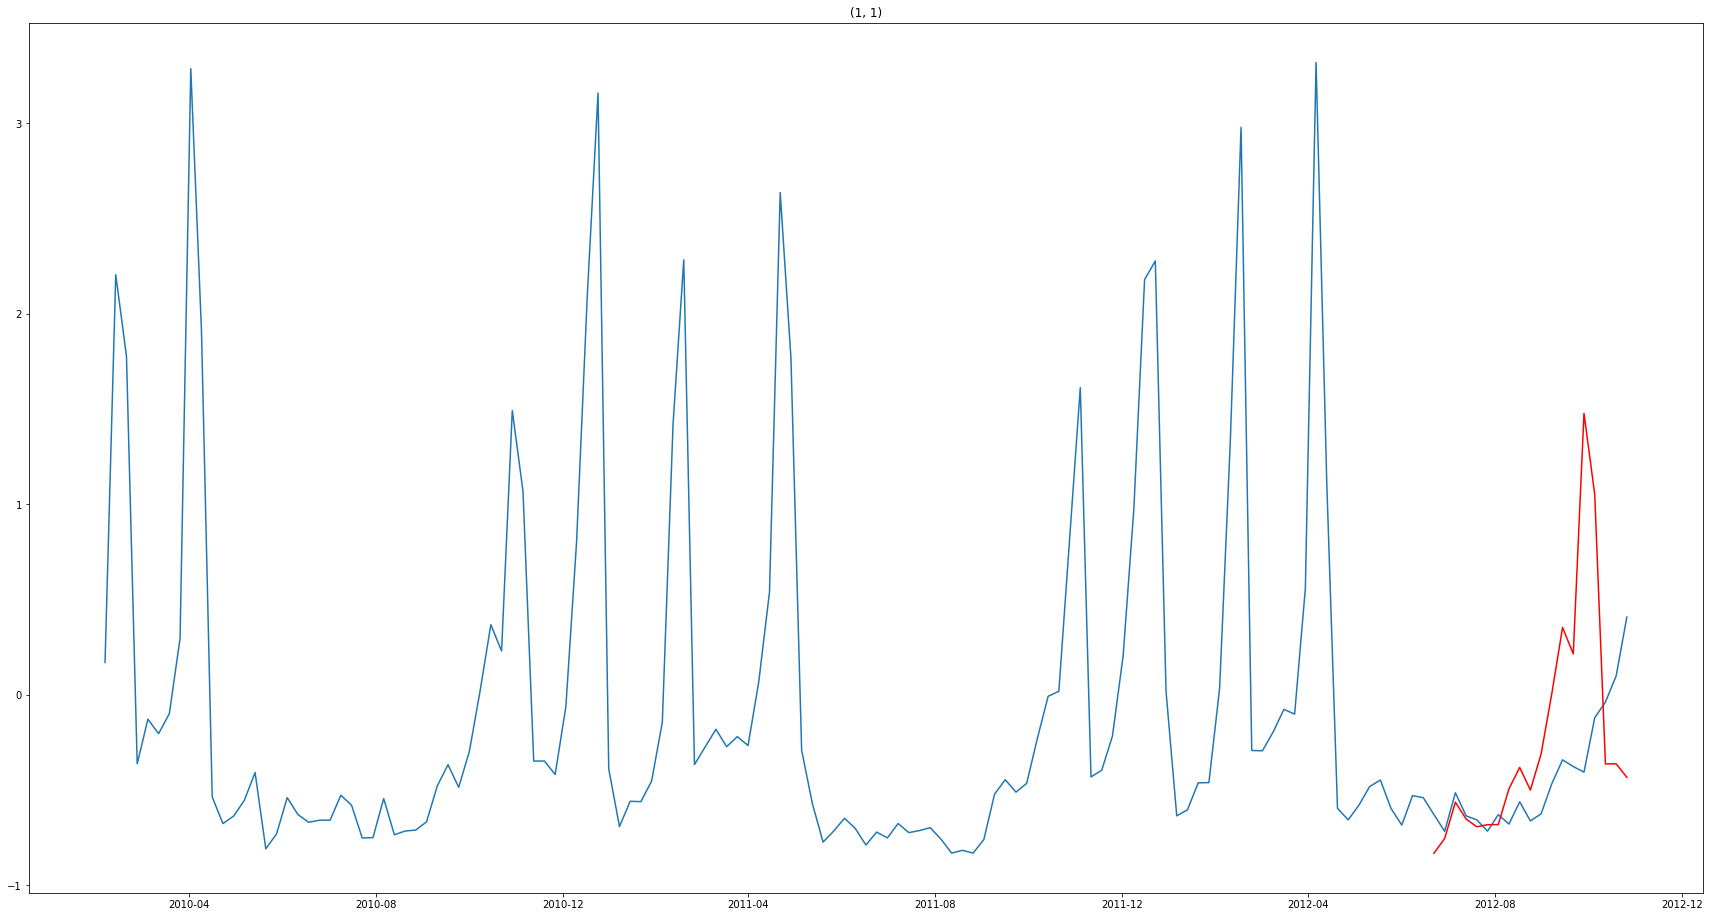

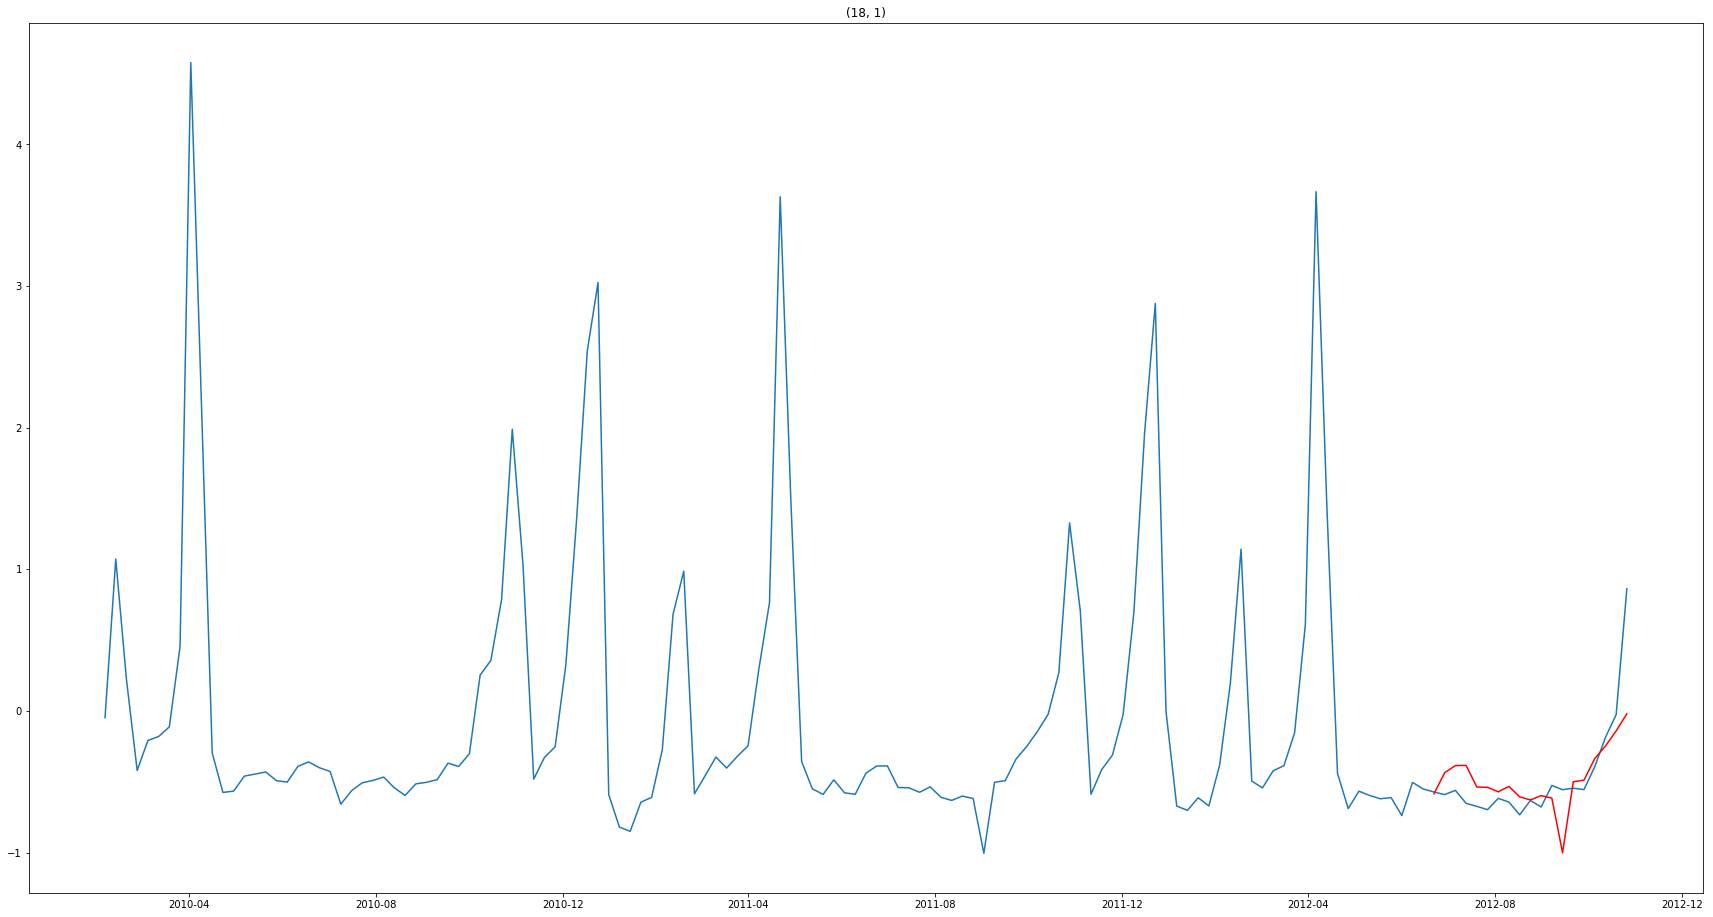

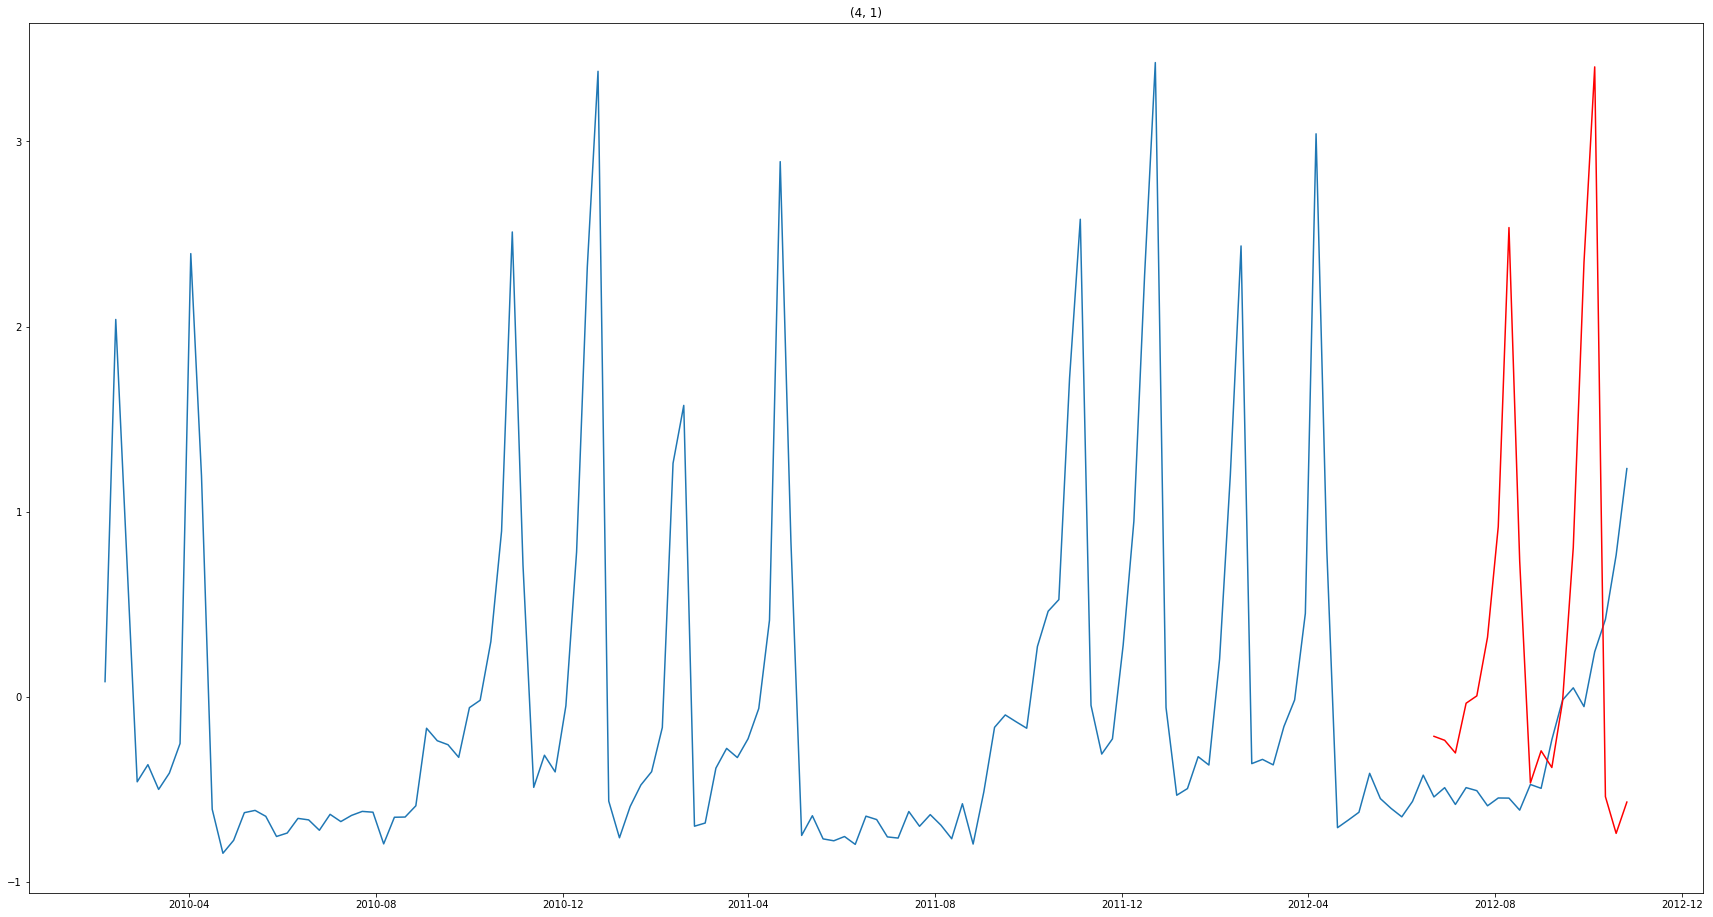

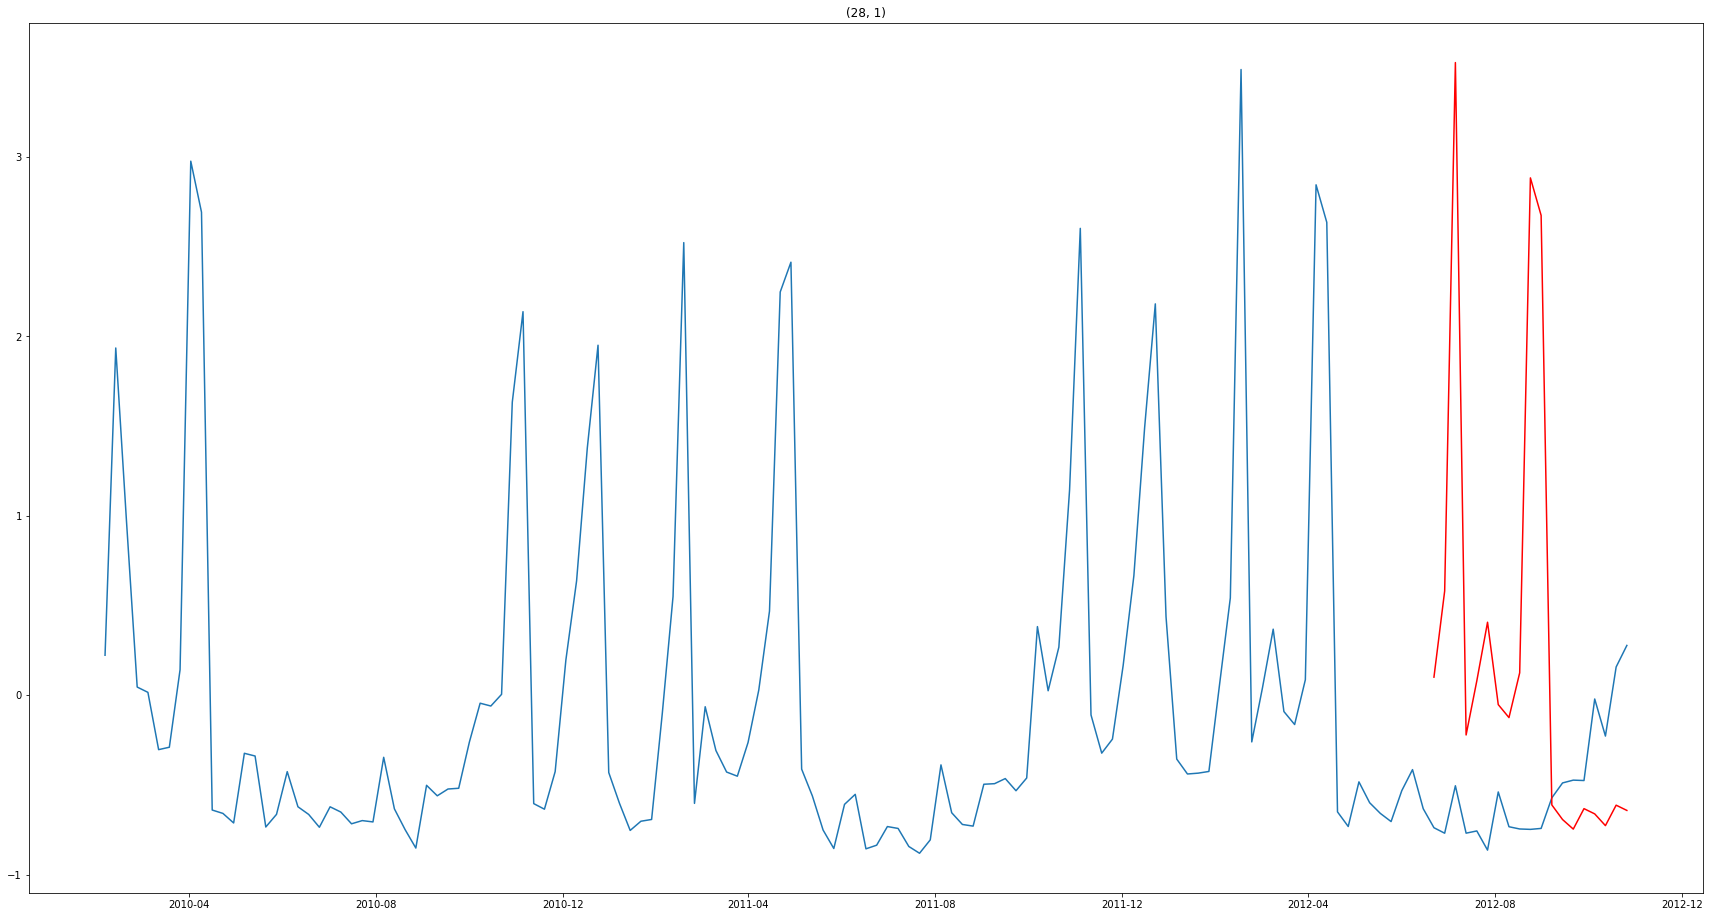

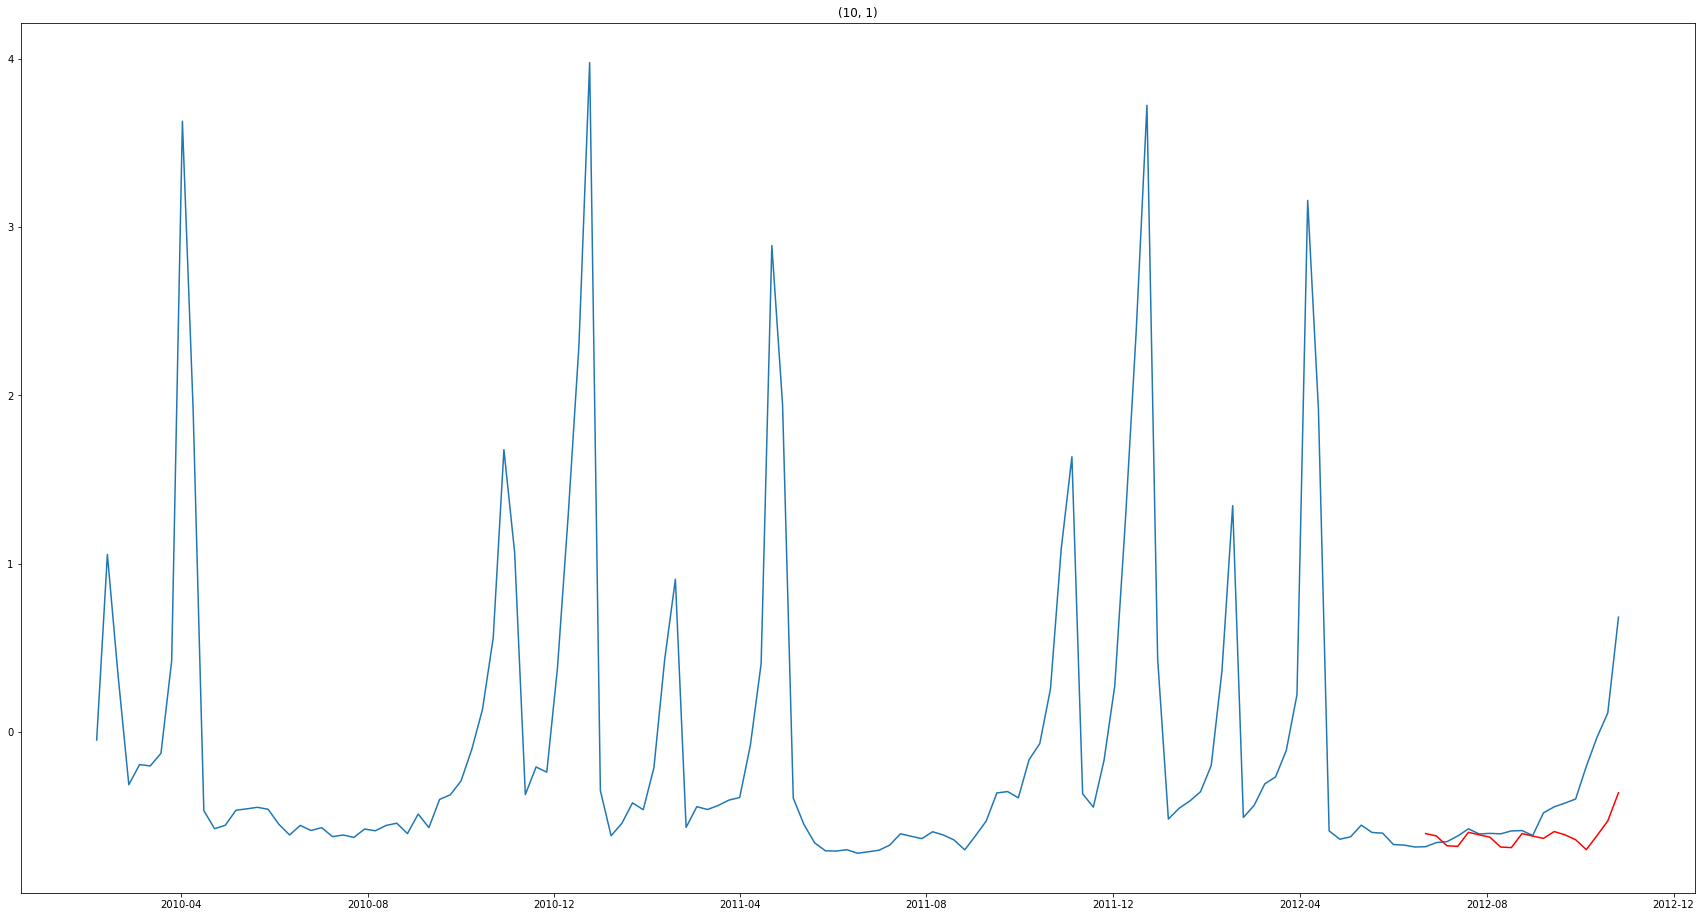

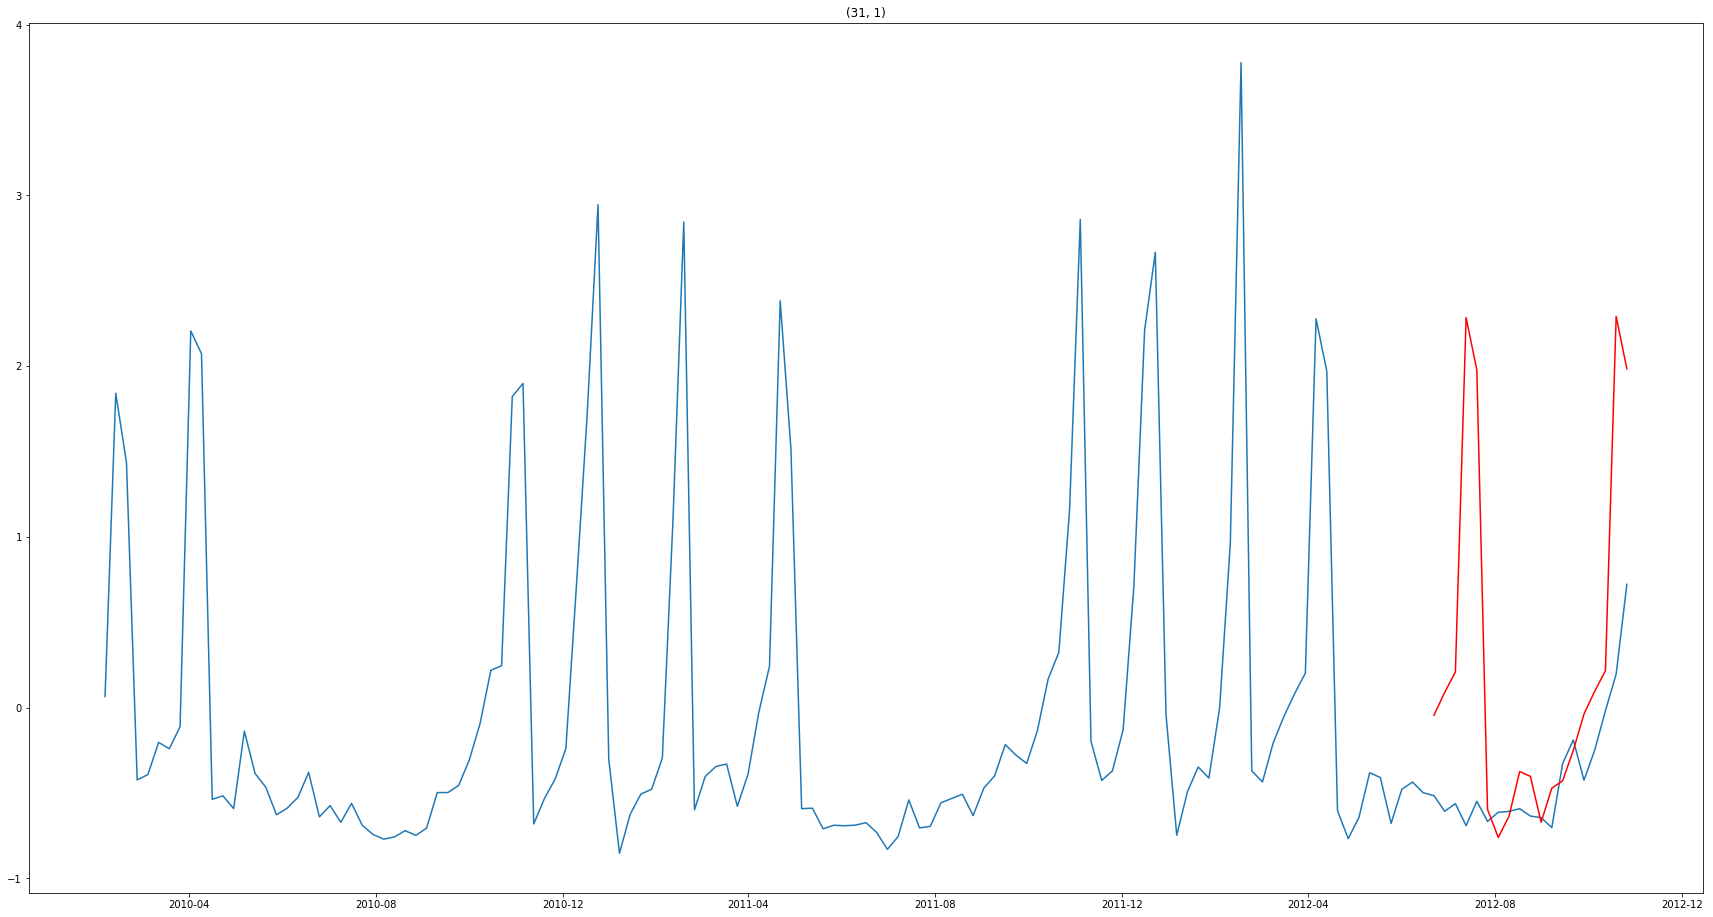

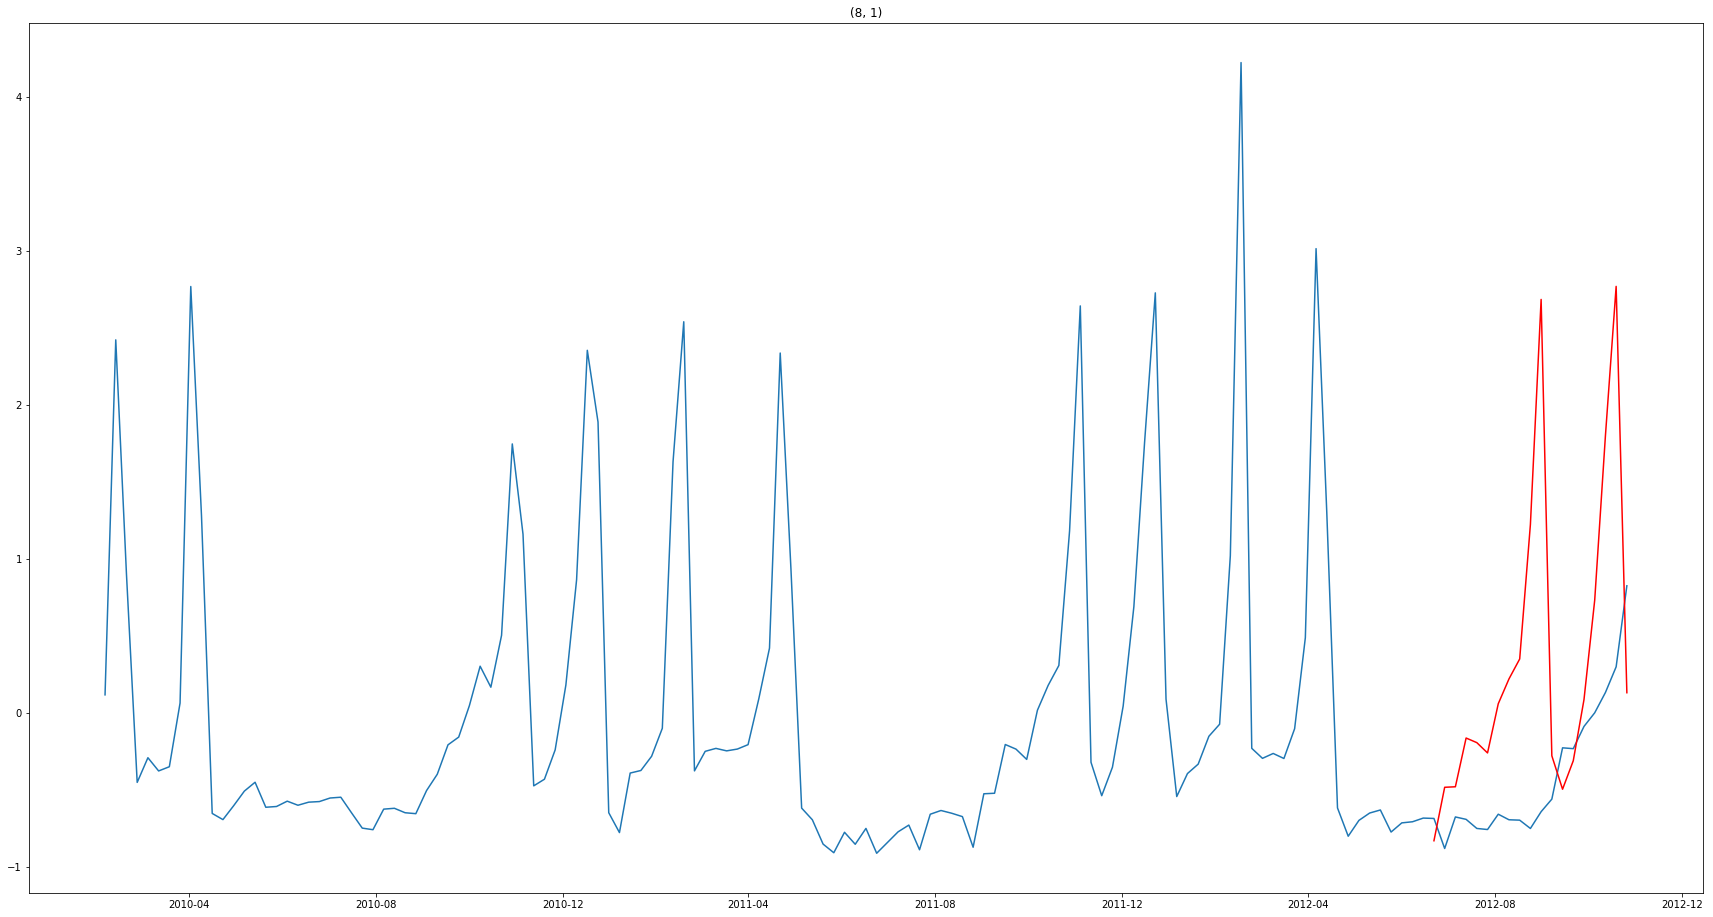

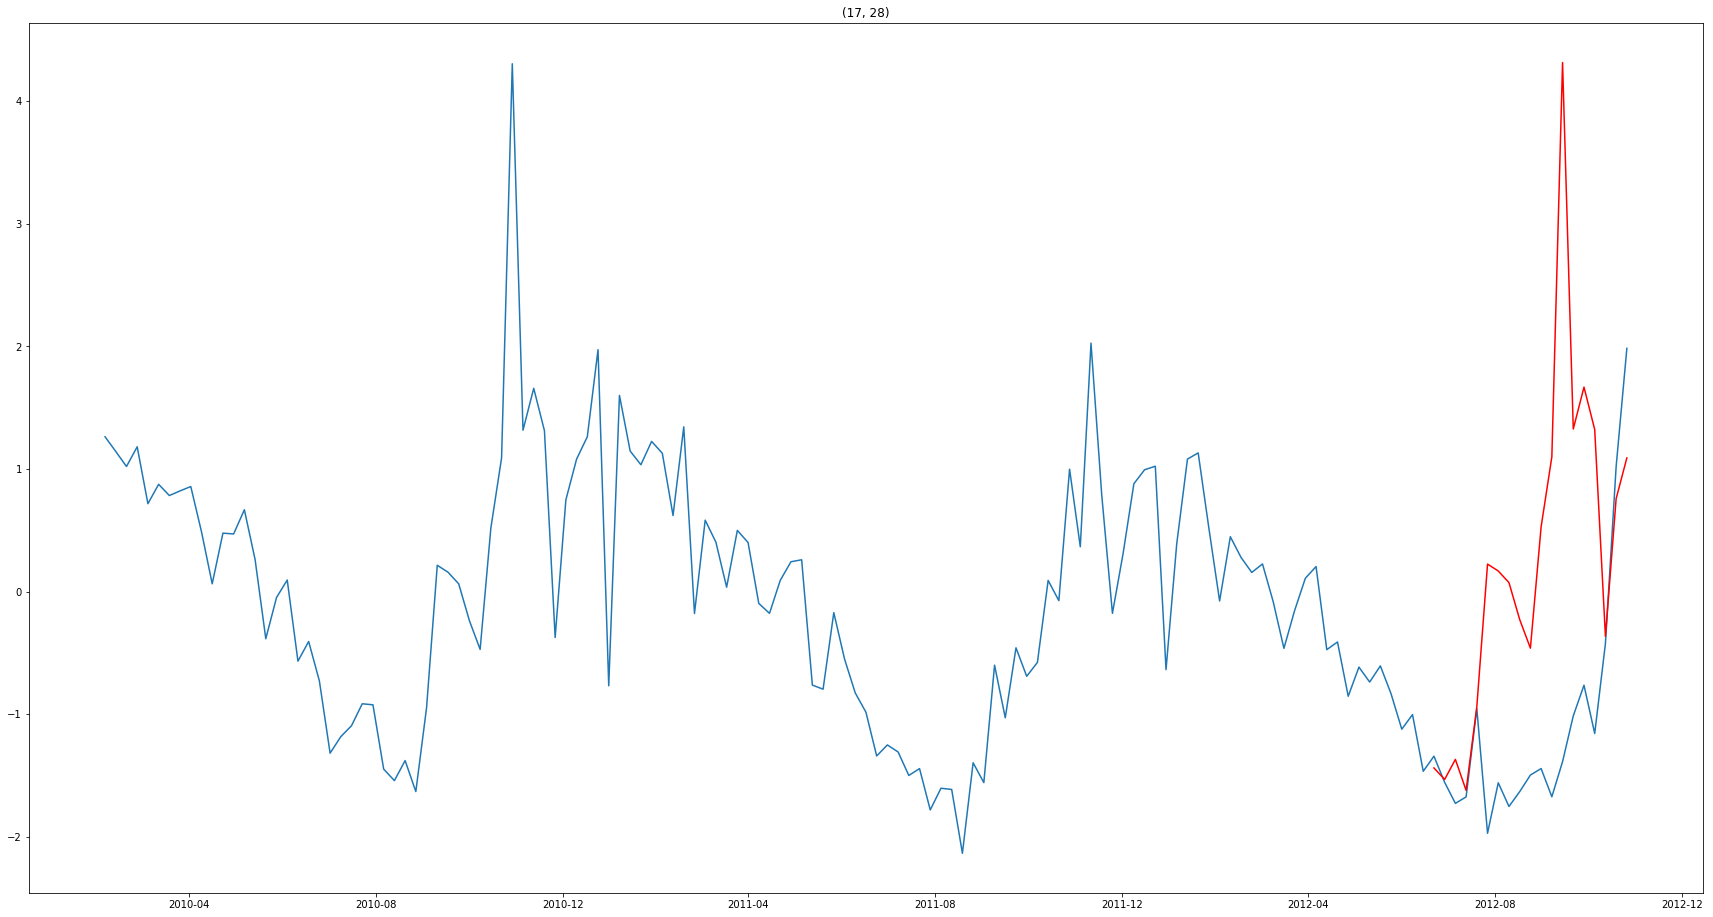

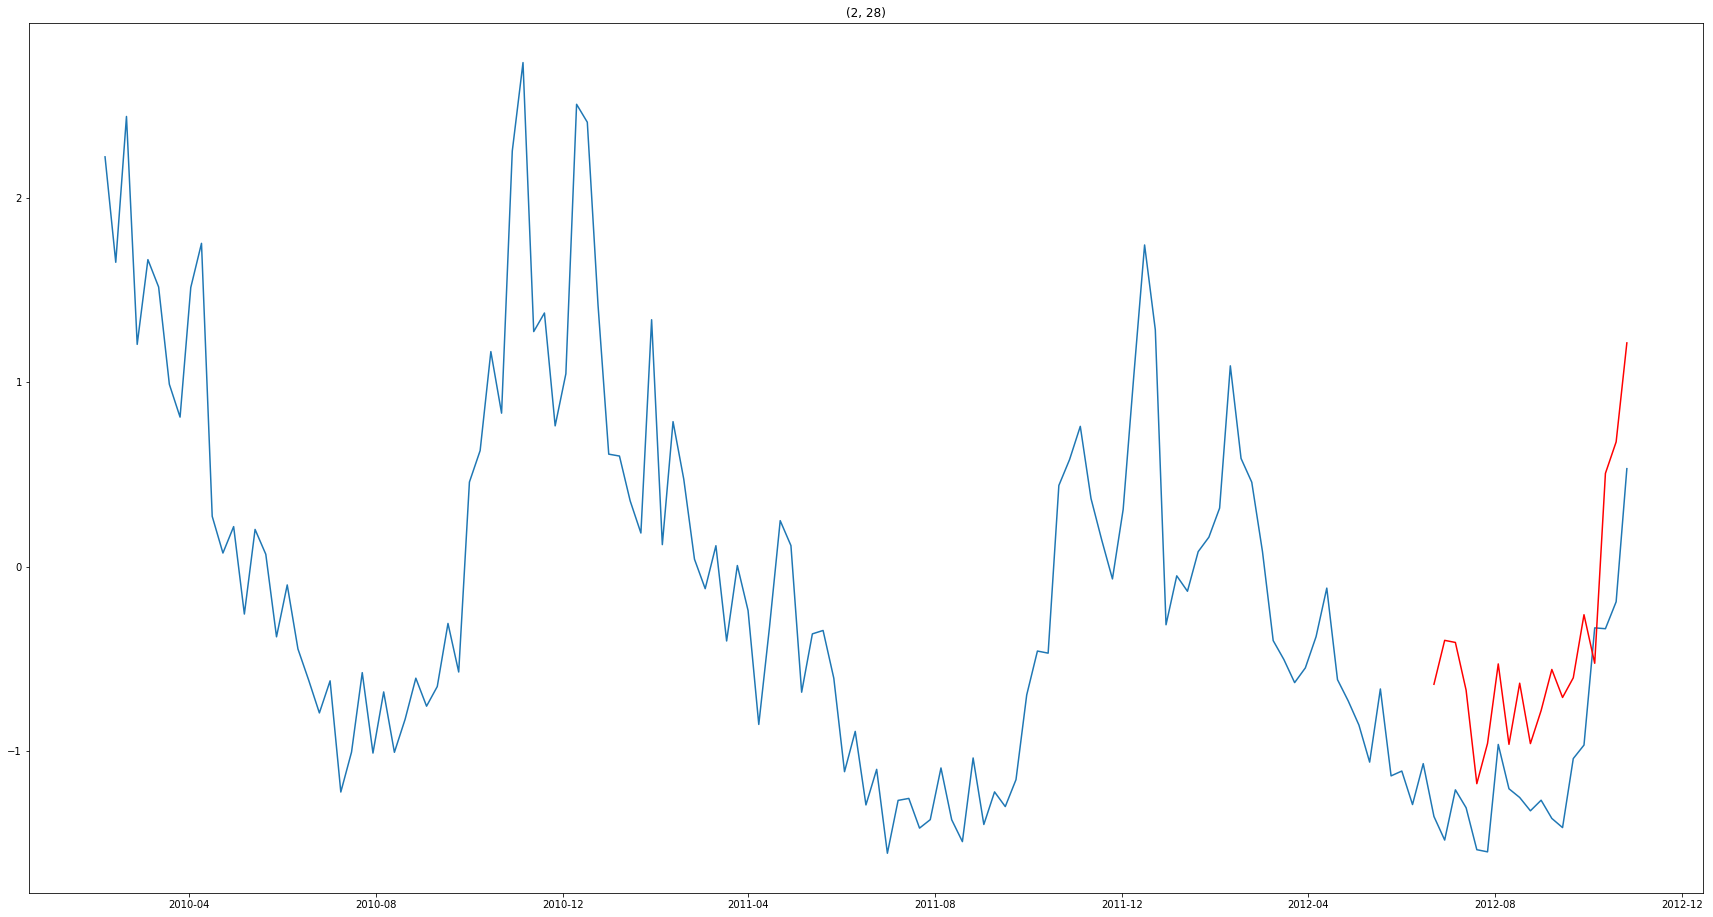

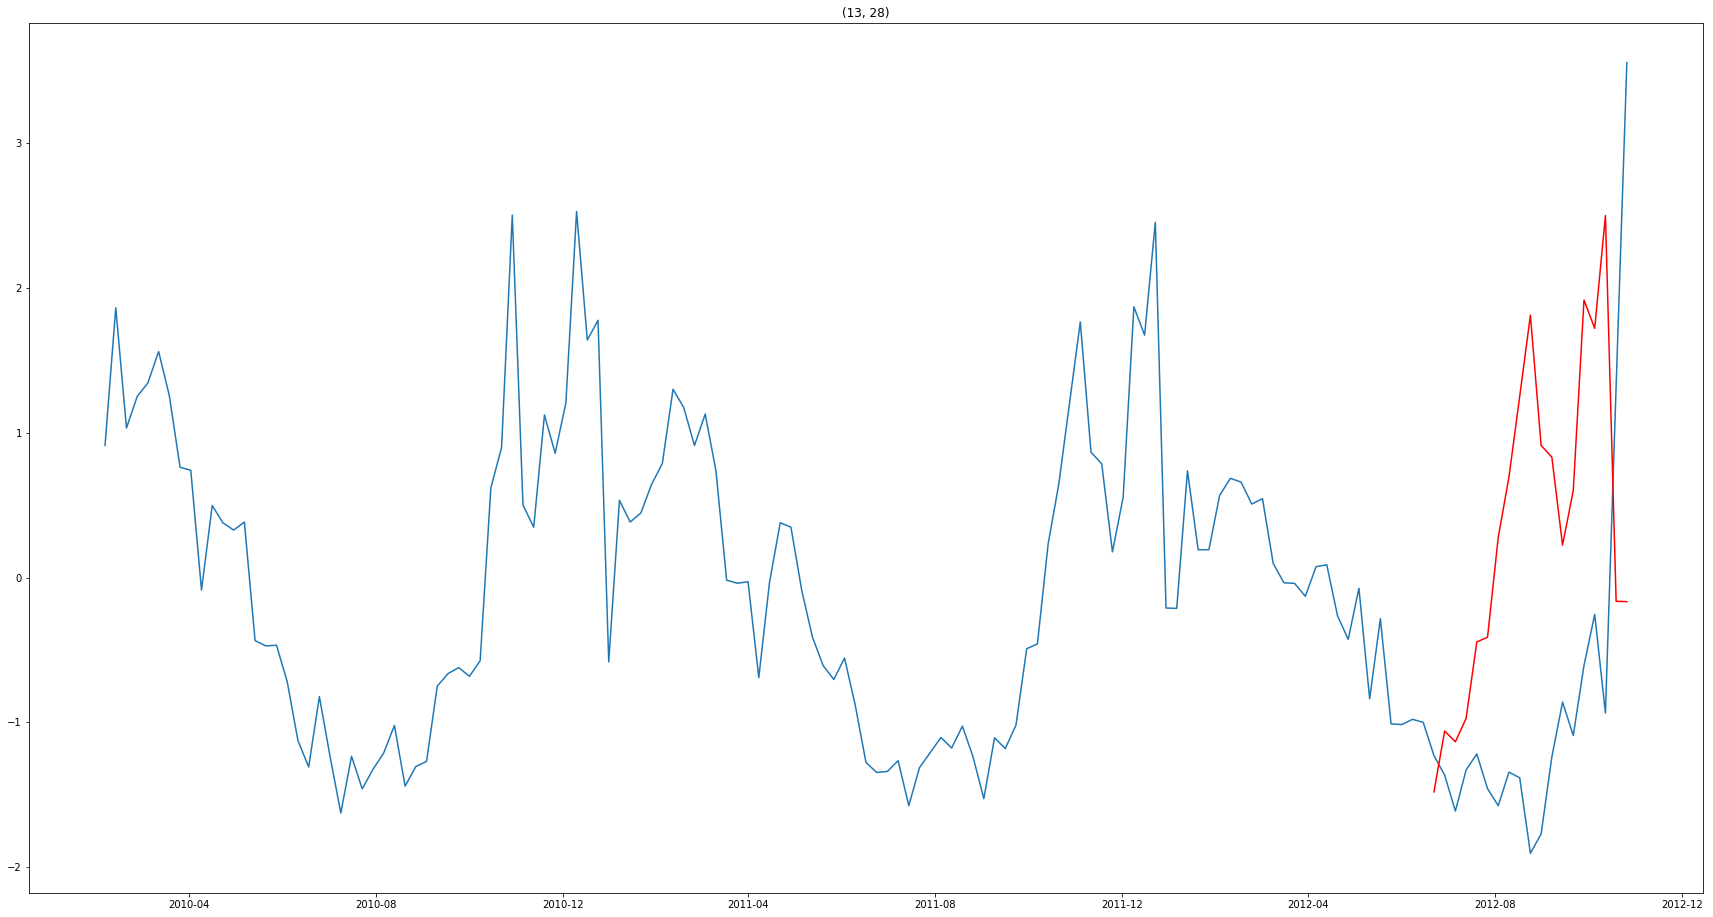

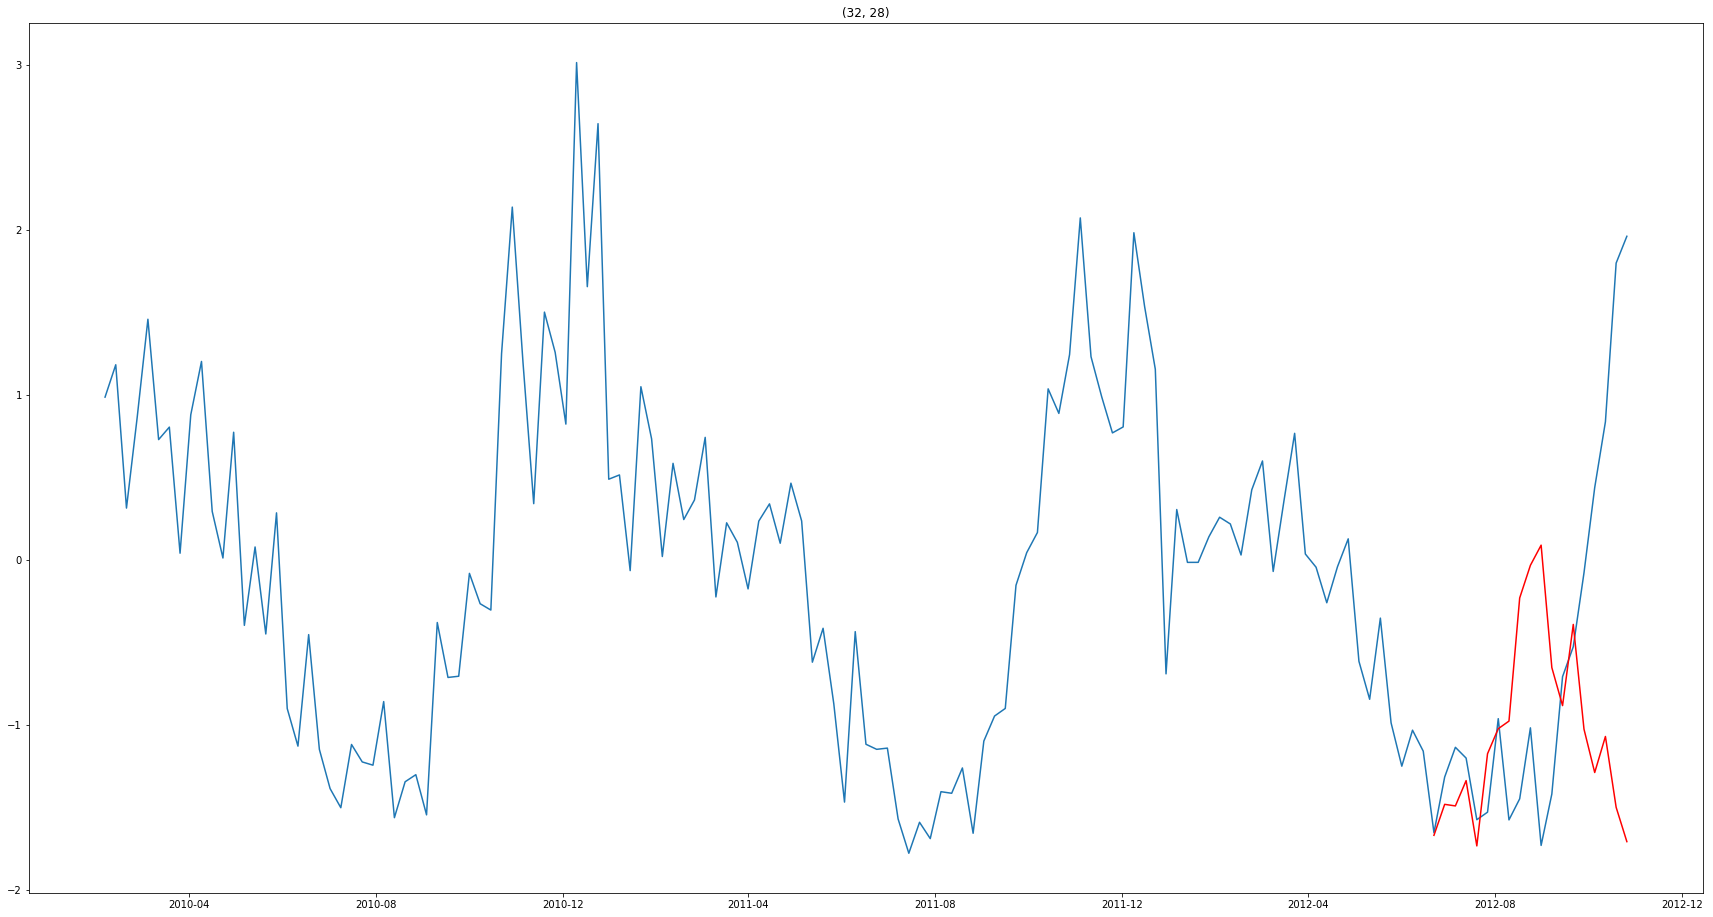

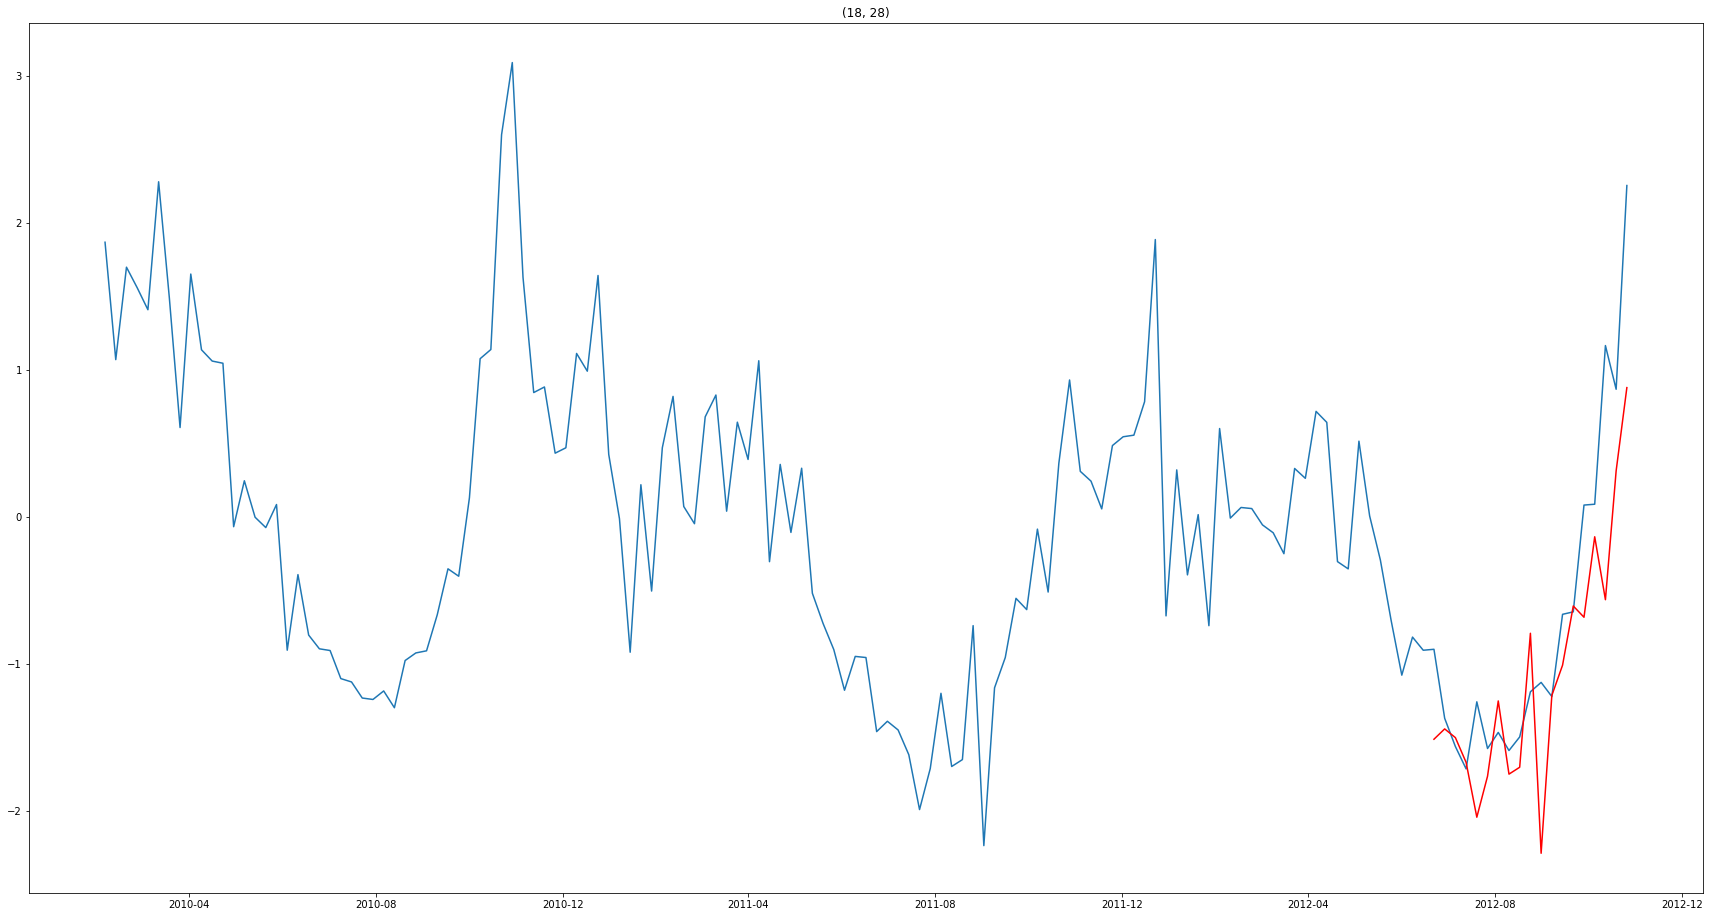

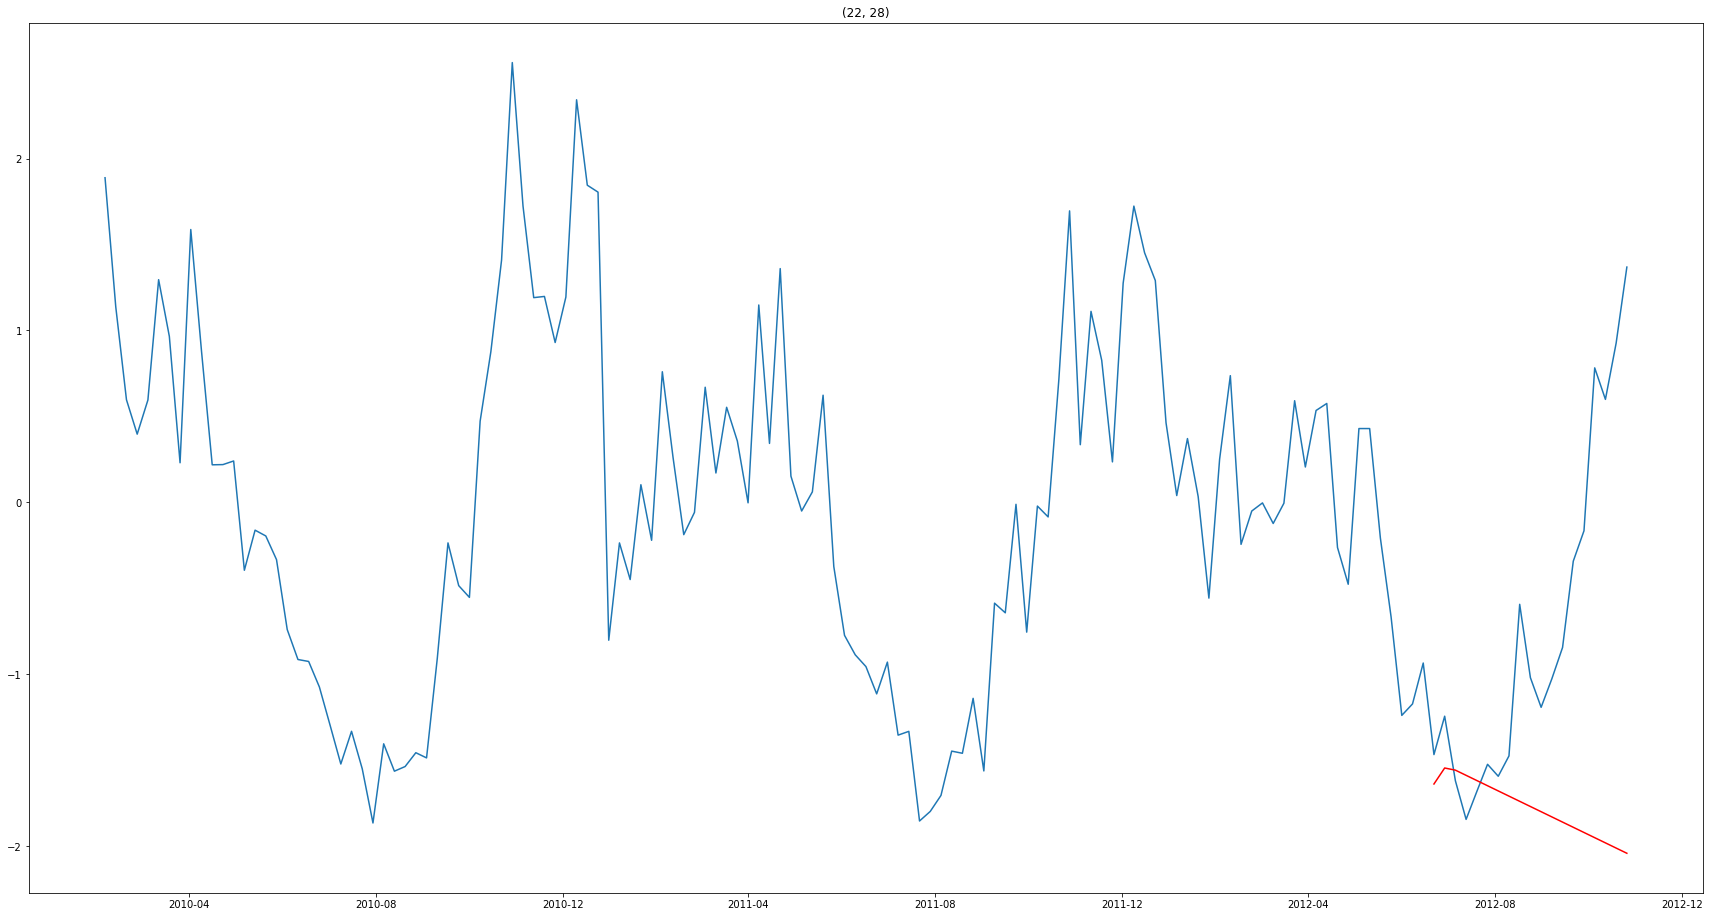

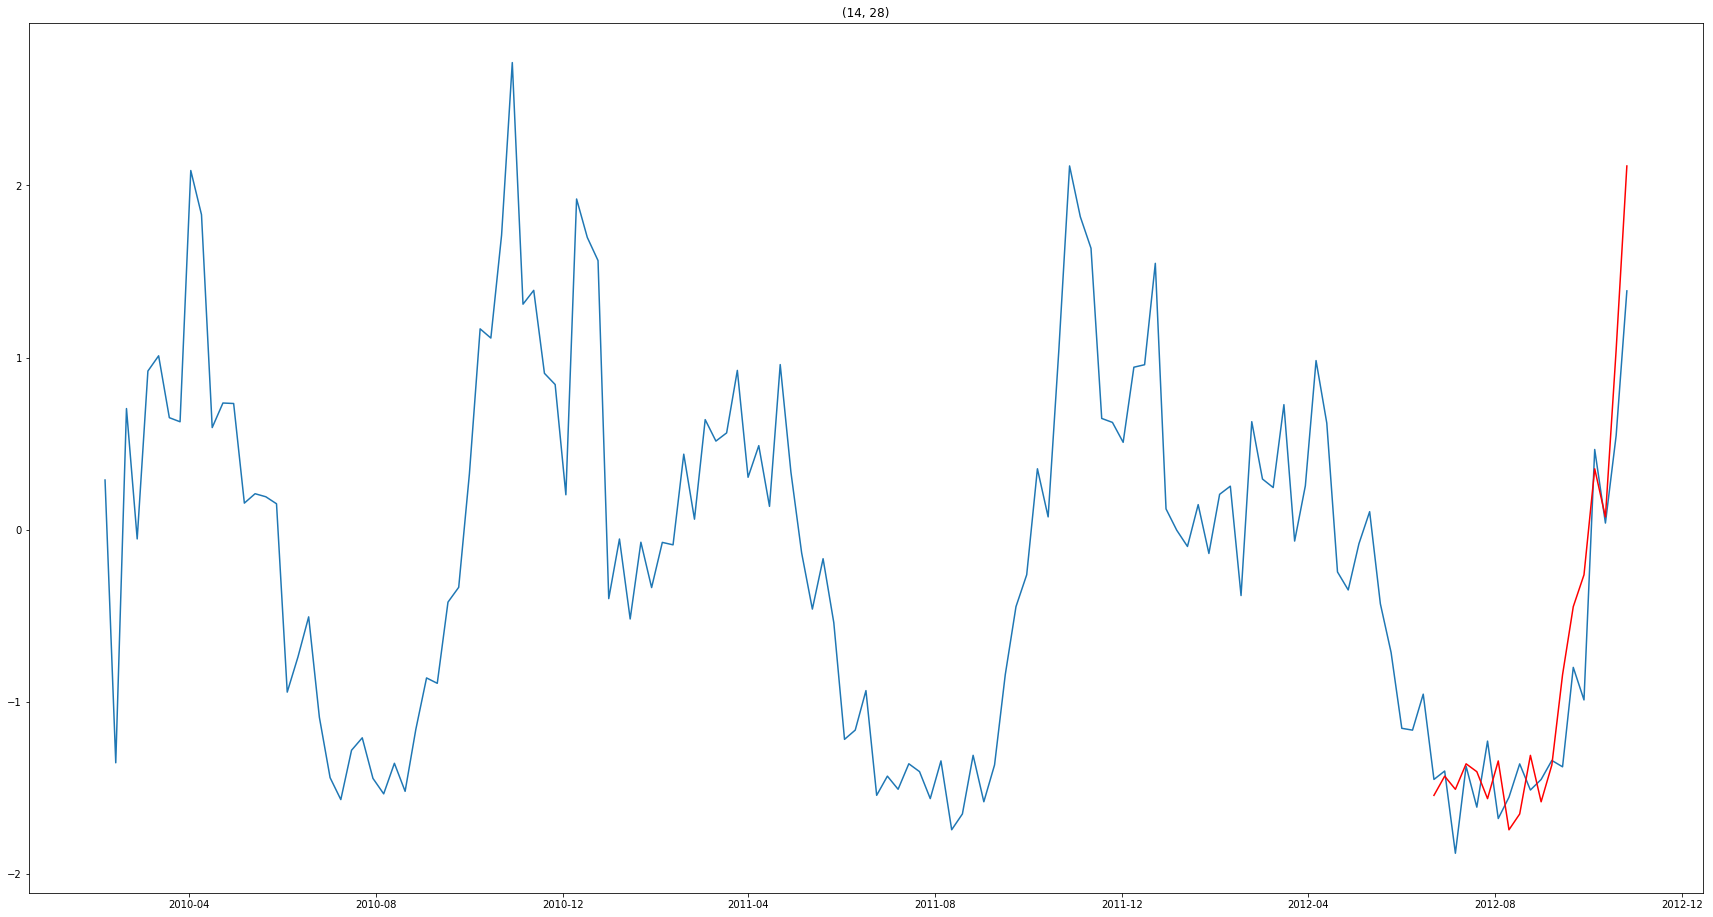

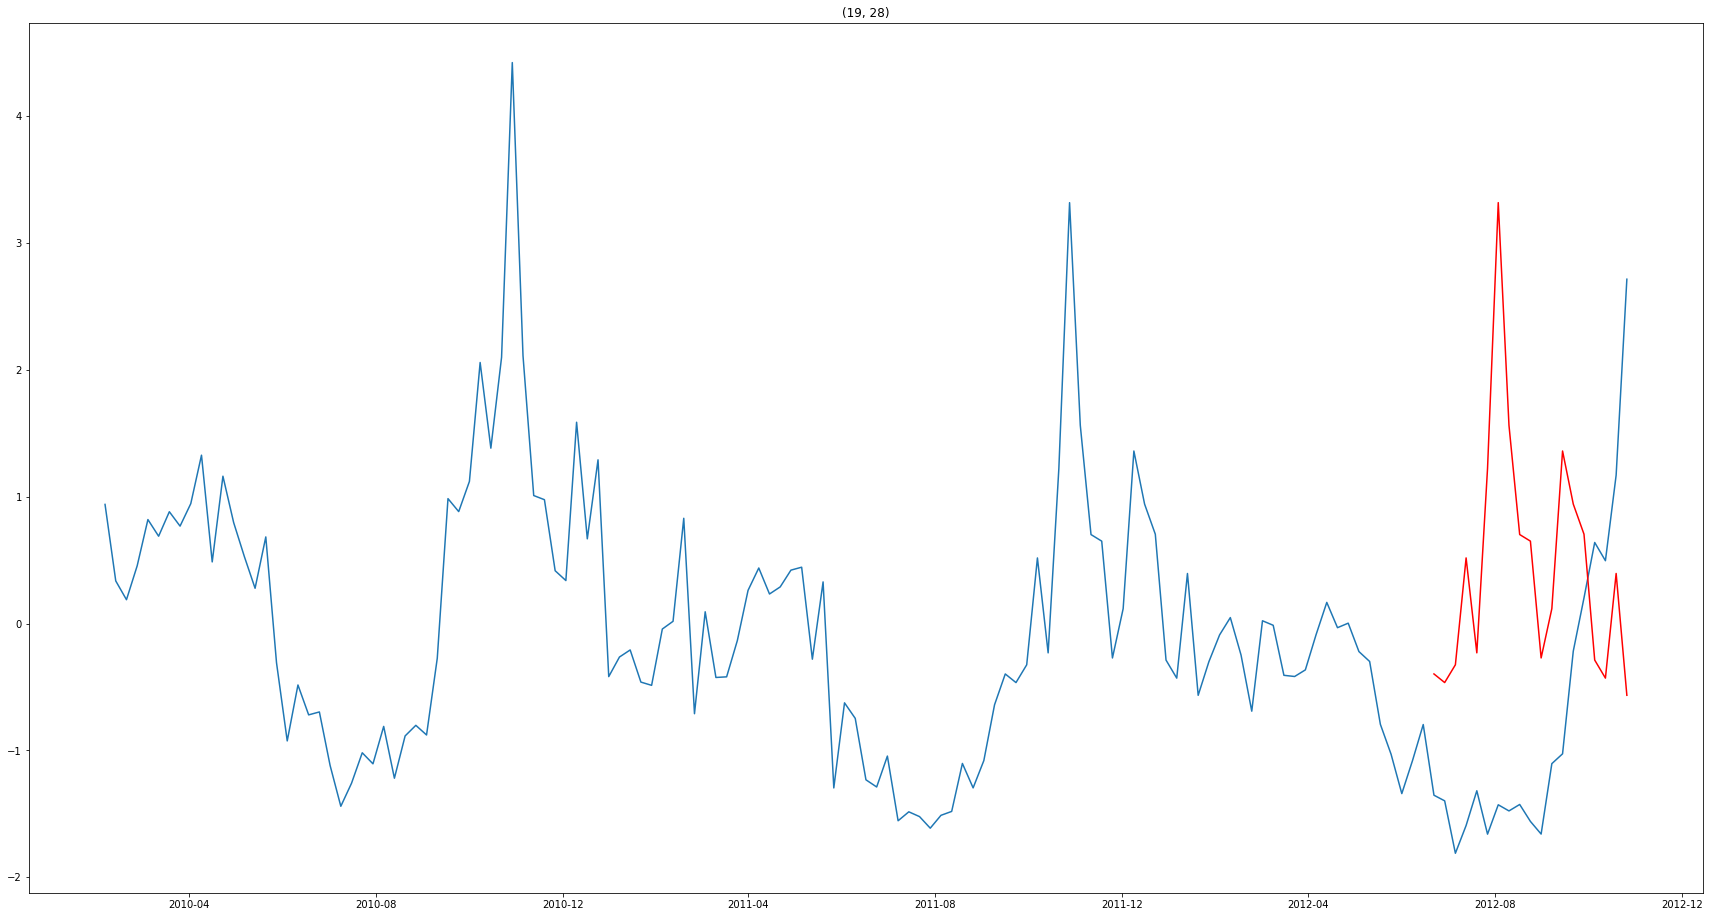

In [10]:
importlib.reload(knntsp)

cr_errors = 0
for result in cluster_real:
    current_X, current_Y, mean_error, w, k, cluster_label = result
    cr_errors += mean_error[0]

cp_errors = 0
for result in cluster_predicted:
    current_X, current_Y, mean_error, w, k, cluster_label = result
    cp_errors += mean_error[0]

sr_errors = 0
for result in simple_real:
    current_X, current_Y, mean_error, w, k, cluster_label = result
    sr_errors += mean_error[0]

sp_errors = 0
for result in simple_predicted:
    current_X, current_Y, mean_error, w, k, cluster_label = result
    sp_errors += mean_error[0]
    
print('Cluster real: ', cr_errors/len(cluster_real))
print('Cluster predicted: ', cp_errors/len(cluster_real))
print('Simple real: ', sr_errors/len(cluster_real))
print('Simple predicted: ', sp_errors/len(cluster_real))
for result in simple_predicted[:30]:
    current_X, current_Y, mean_error, w, k, cluster_label = result
    plt.figure(figsize=(30,16,))
    plt.title(current_X.columns[0])
    
    # Plot sem o valor real
    # plt.plot(X[:len(X) - len(predicted)])
    
    # Plot com o valor real
    plt.plot(current_X)
    
    plt.plot(pd.DataFrame(current_Y, index=current_X.index[len(current_X)-len(current_Y) +1: len(current_X)]), color='red')
    plt.show()

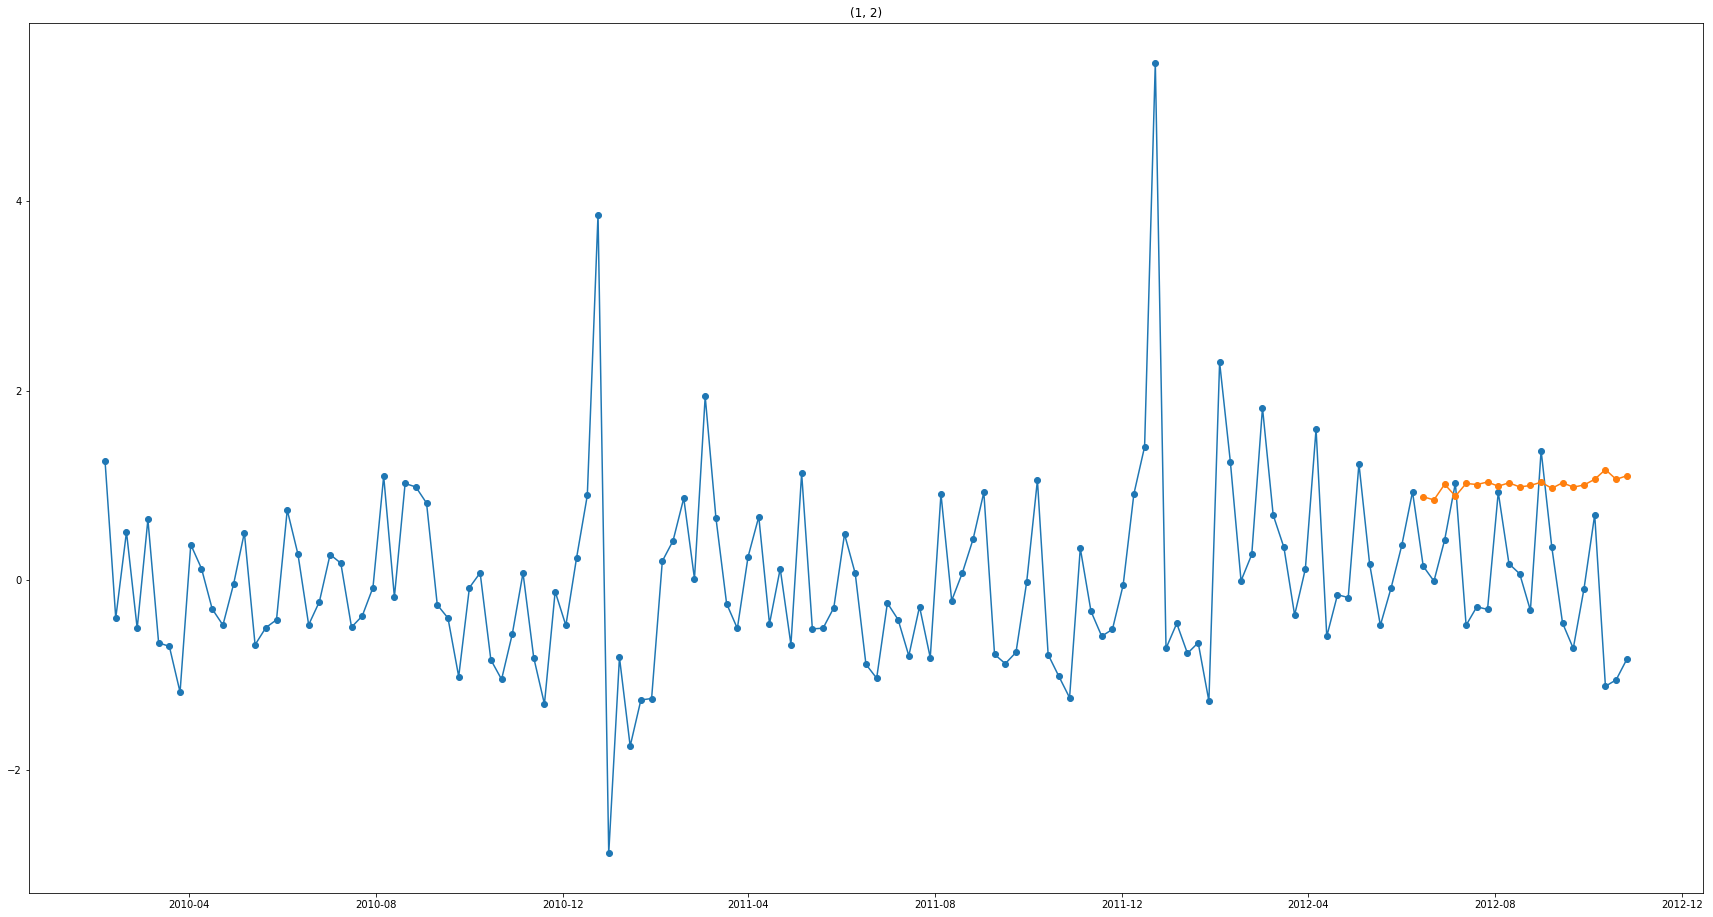

In [32]:
importlib.reload(knntsp)

# current_X, current_Y, mean_error, w, k, cluster_label = knntsp.predict_with_knn(timeSeries, timeSeries.columns.values[0], 27, 4, TRAIN_SIZE, False, False)
current_X, current_Y, mean_error, w, k, cluster_label = knntsp.predict_with_cluster_knn(timeSeries, timeSeries.columns.values[1], cluster_labels, 27,27, TRAIN_SIZE, False, False)
plt.figure(figsize=(30,16,))
plt.title(current_X.columns[0])

# Plot sem o valor real
# plt.plot(X[:len(X) - len(predicted)])

# Plot com o valor real
plt.plot(current_X, marker='o')
# plt.plot(pd.DataFrame(current_Y, index=current_X.index[len(current_X)-len(current_Y) +1: len(current_X)]), color='red')
plt.plot(current_Y, marker='o')
plt.show()

In [35]:

import sys 
print(sys.executable)
!{sys.executable} -m pip install cdtw
from cdtw import pydtw

C:\ProgramData\Anaconda3\python.exe
  Running setup.py bdist_wheel for cdtw: started
  Running setup.py bdist_wheel for cdtw: finished with status 'done'
  Stored in directory: C:\Users\gabri\AppData\Local\pip\Cache\wheels\b9\56\01\29f275628dcfdcd590b6c1a15178e22e2c29d21c3bde3942f1
Successfully built cdtw


twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [94]:
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
def dfun(u, v):
    return pydtw.dtw(u,v,pydtw.Settings(step = 'p0sym', window = 'palival', param = 2.0, norm = False, compute_path = False)).get_dist()
XX=pd.DataFrame(StandardScaler().fit_transform(X.iloc[:-20]), index=X.index[:-20], columns=X.columns)
dm = pdist(XX.T, dfun)
# pydtw.dtw(s1,s2,pydtw.Settings(step = 'p0sym', window = 'palival', param = 2.0, norm = False, compute_path = False)).get_dist()

In [95]:
from scipy.spatial.distance import squareform
dmm = squareform(dm)

In [96]:
dmm.shape

(2660, 2660)

In [97]:
from sklearn.cluster import AffinityPropagation
clustering = AffinityPropagation().fit(dmm)

In [98]:
pd.Series(clustering.labels_).max()

98

In [99]:
def plot_silhouette(timeSeries, silhouette_avg, n_clusters, cluster_labels, pic_name=None):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 18)

    ax1.set_xlim([-0.1, 1])

    ax1.set_ylim([0, len(timeSeries) + (n_clusters + 3) * 10])
    y_lower = 10
    
    sample_silhouette_values = metrics.silhouette_samples(timeSeries, cluster_labels)
    silhouette_values = []
    
    for i in range(0, cluster_labels.max() + 1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        
        if ith_cluster_silhouette_values.shape[0] > 0:
            ith_cluster_silhouette_values.sort()
            silhouette_values.append(ith_cluster_silhouette_values)

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
        else:
            silhouette_values.append(pd.Series([]))

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1.0, -0.9,  -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    if pic_name:
        fig.savefig(IMAGES_PATH + pic_name + '.png')
    plt.suptitle(("Silhouette analysis for Time Series Clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    return pd.Series(silhouette_values)

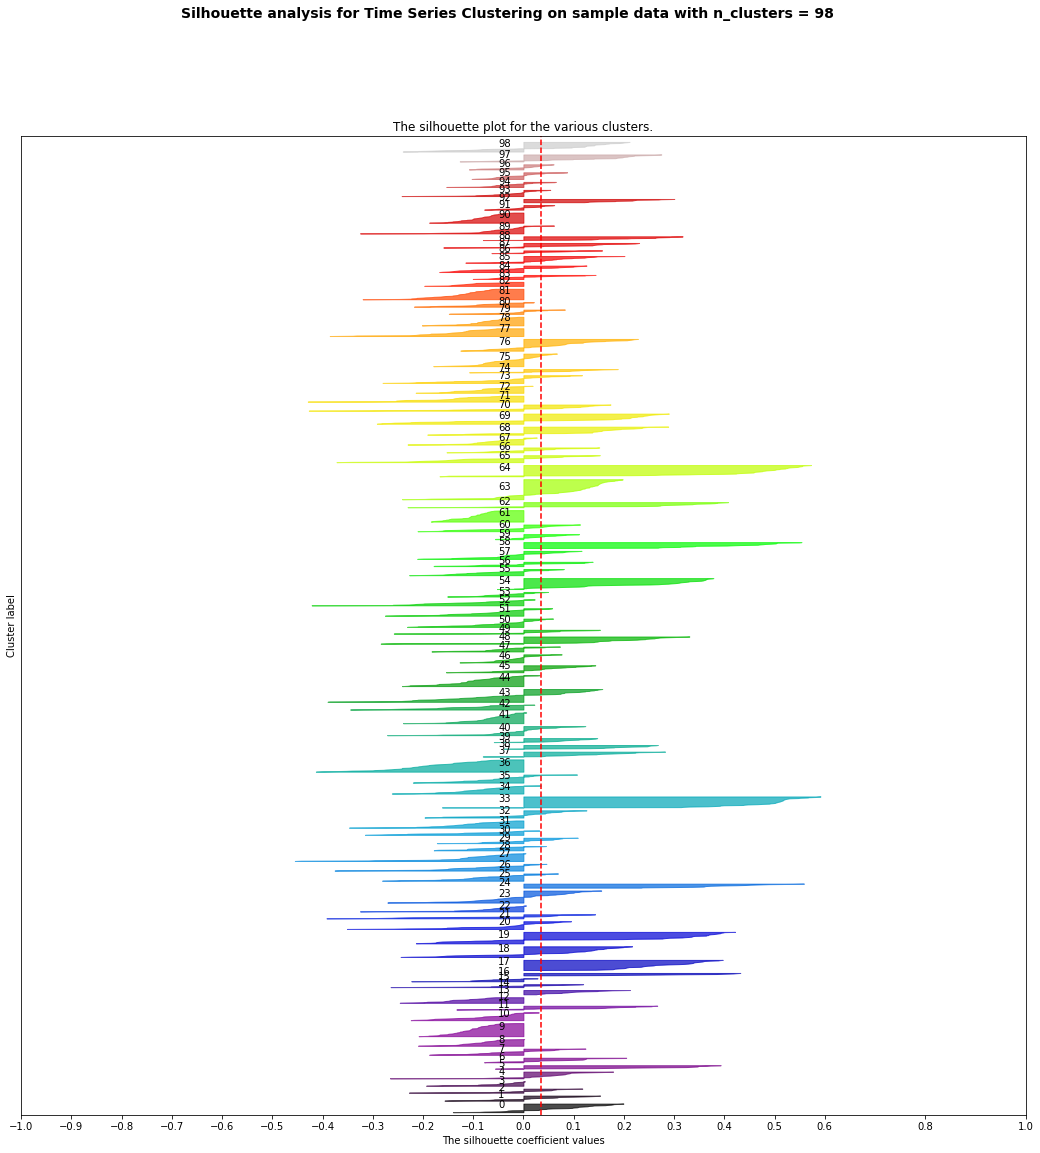

In [103]:
#Nice graphing tools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly
import plotly.offline as py
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.tools as tls

import scipy.cluster.hierarchy as hac
from scipy.cluster.hierarchy import cophenet, fcluster
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
avg = metrics.silhouette_score(dmm, clustering.labels_, metric='precomputed')
kk = plot_silhouette(XX.T, avg, 98, clustering.labels_)

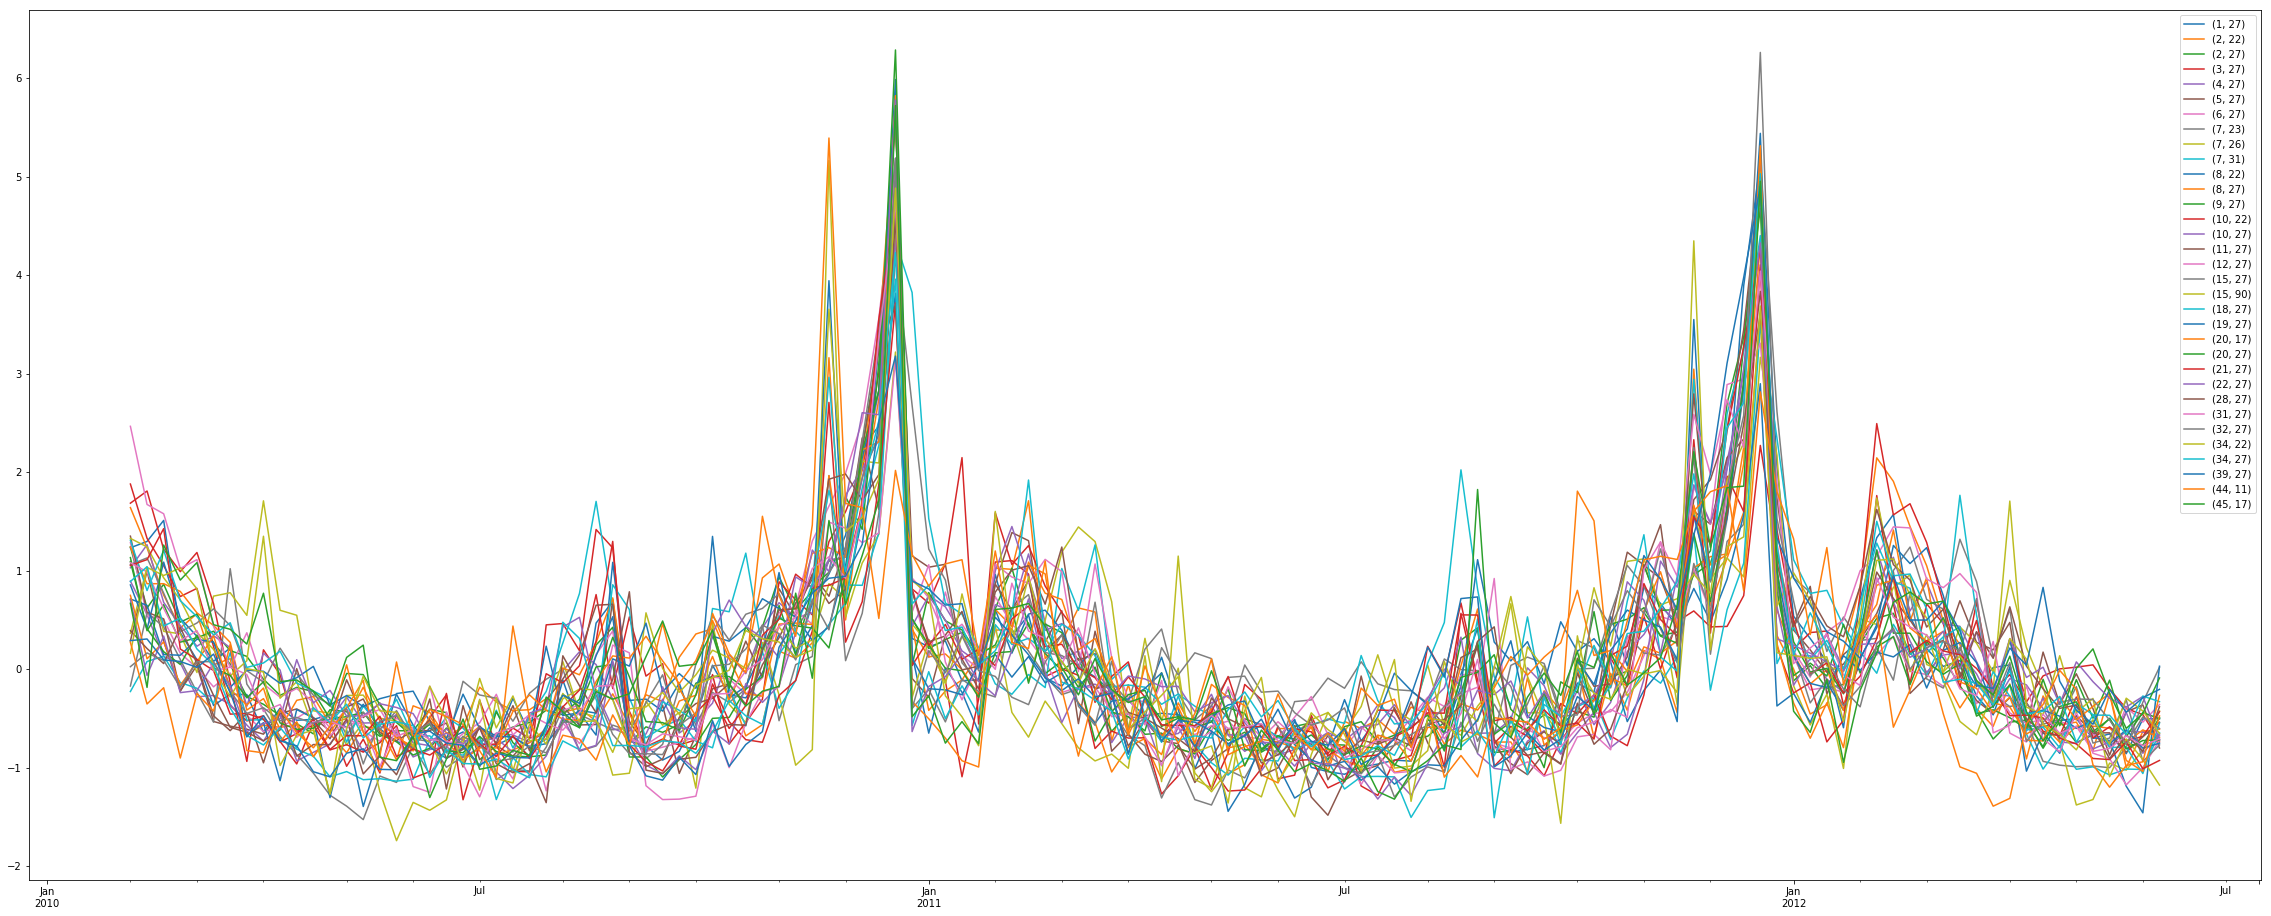

In [105]:
XX.T.loc[clustering.labels_==0].T.plot(figsize=(40,16))
# 
# clustering.labels_.shape

pd.Series(clustering.labels_).to_csv(PREPROCESSED_PATH + 'dtw_affinity_based_cluster_labels.csv')